# Libraries

In [1]:
# Librerias
import matplotlib.pyplot as plt
import os
# Números y Datos
import numpy as np
import networkx as nx
from networkx.algorithms.approximation import average_clustering
import community.community_louvain
from collections import Counter
import pickle
# Para visuzalización en notebook
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
# Números y Datos
import pandas as pd
import powerlaw
from sklearn.metrics import adjusted_rand_score
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import defaultdict
import subprocess

# Bajar Datos

Usamos Airport y Facebook


In [2]:
urls = {
    "airport.txt": "https://www.dropbox.com/scl/fi/nk8yvhez5ylhd6blzf77o/airport.txt?rlkey=3cf24r6yij8uu0fakb68yztlm&dl=1",
    "facebook.txt": "https://www.dropbox.com/scl/fi/hdgcmyss47w9t676kh2ug/facebook.txt?rlkey=j616y86ejfn6f719jg4b8e413&dl=1",
    "airportStronglyConn_pos.pkl": "https://www.dropbox.com/scl/fi/eebzjgqazi8b02bkkrxmf/airStrongly_positions.pkl?rlkey=cyhifzsgrls5vdlycrb1gnykv&st=6lozmqe6&dl=1",
    "fb_pos.pkl": "https://www.dropbox.com/scl/fi/ka6v0h9ew5j08haxlbf6b/fb_positions.pkl?rlkey=7ul7jr7re&st=vp6gjciw&dl=1"
}

for filename, url in urls.items():
    print(f"Descargando {filename}...")
    subprocess.run(["curl", "-L", "-o", filename, url], check=True)
print("✅ Descarga completada.")


Descargando airport.txt...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100    17  100    17    0     0     44      0 --:--:-- --:--:-- --:--:--    44
100  320k  100  320k    0     0   559k      0 --:--:-- --:--:-- --:--:--  559k


Descargando facebook.txt...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17  100    17    0     0     38      0 --:--:-- --:--:-- --:--:--    38
100  834k  100  834k    0     0  1418k      0 --:--:-- --:--:-- --:--:-- 8691k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Descargando airportStronglyConn_pos.pkl...


100    17  100    17    0     0     42      0 --:--:-- --:--:-- --:--:--    43
100   496    0   496    0     0    860      0 --:--:-- --:--:-- --:--:--   860
100 91307  100 91307    0     0   119k      0 --:--:-- --:--:-- --:--:--  119k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Descargando fb_pos.pkl...


  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

✅ Descarga completada.


100  161k    0  161k    0     0   304k      0 --:--:-- --:--:-- --:--:--  304k


# Funciones útiles

In [3]:
#Para cargar datos
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_graph_weighted(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def read_dir_graph(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

def read_dir_graph_weighted(filename):
    G = nx.DiGraph()
    array = np.loadtxt(filename, dtype=int)
    G.add_weighted_edges_from(array)
    return G

def get_graph_pos(filename):
  with open(filename, 'rb') as f:
    posData = pickle.load(f)
  return posData

#Borrarle los pesos a un grafo pesado
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

#Para calcular eficientemente en grafos muy grandes una aproximación a distancias mínimas medias, $<d>$**
def sample_path_lengths(G, nodes=None, trials=1000):
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = [nx.shortest_path_length(G, *pair)
               for pair in pairs]
    return lengths

def estimate_path_length(G, nodes=None, trials=1000):
    return np.mean(sample_path_lengths(G, nodes, trials))

# Preludio

**Características de las redes**

In [4]:
fb = read_graph('facebook.txt')
print('Facebook')
print(fb)
print('Es dirigido?:',nx.is_directed(fb))
print('Es pesado?:',nx.is_weighted(fb))
print('Es conectado?:',nx.is_connected(fb))
print('')

air = read_dir_graph_weighted('airport.txt')
print('Airport')
print(air)
print('Es dirigido?:',nx.is_directed(air))
print('Es pesado?:',nx.is_weighted(air))
print('Es fuertemente conexo?:',nx.is_strongly_connected(air))
print('Es debilmente conexo?:',nx.is_weakly_connected(air))

airStronglyCC = sorted(nx.strongly_connected_components(air), key=len, reverse=True)
airStrongly = air.subgraph(airStronglyCC[0]) # la mas grande en 0 y así en orden
print('Airport componente gigante fuertemente conexa')
print(airStrongly)
print('Es dirigido?:',nx.is_directed(airStrongly))
print('Es pesado?:',nx.is_weighted(airStrongly))
print('Es fuertemente conexo?:',nx.is_strongly_connected(airStrongly))
print('Es debilmente conexo?:',nx.is_weakly_connected(airStrongly))
print('')

airUndir=nx.DiGraph.to_undirected(airStrongly)
airU = airUndir.copy()
drop_weights(airU)
print('C. air (unweighted)')
print(airU)
print('Es dirigido?:',nx.is_directed(airU))
print('Es pesado?:',nx.is_weighted(airU))
print('Es conectado?:',nx.is_connected(airU))
print('')

Facebook
Graph with 4039 nodes and 88234 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True

Airport
DiGraph with 1574 nodes and 28236 edges
Es dirigido?: True
Es pesado?: True
Es fuertemente conexo?: False
Es debilmente conexo?: False
Airport componente gigante fuertemente conexa
DiGraph with 1402 nodes and 28032 edges
Es dirigido?: True
Es pesado?: True


Es fuertemente conexo?: True
Es debilmente conexo?: True

C. air (unweighted)
Graph with 1402 nodes and 17013 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



# Aeropuertos - Componente gigante de Airport

**Componente Fuertemente Conexa (Strongly Connected):**

1.   Desde cada nodo de la componente existe un camino hacia todos los otros nodos que usa aristas únicamente de la componente.
2.   No hay un nodo del grafo fuera de la componente desde el cual se pueda llegar a la componente y al que se pueda llegar desde ella (si existiera estaría en la componente).

**Componente Débilmente Conexa (Weakly Connected):**


1.  Si al convertir el grafo dirigido en uno no dirigido el grafo resultante es conexo.
**¿Cómo medir distancias en grafos dirigidos?**

1.   Si es un componente fuertemente conexo puedo medir $<d>$ normalmente (con nx.average_shortest_path_length o con estimate_path_length si el grafo es muy grande)
2.   Si es un componente debilmente conexo no puedo medir $<d>$. Primero debo transformar el componente a un grafo no dirigido (con nx.DiGraph.to_undirected) y ahí si medir $<d>$. Pero tomar en cuenta que vamos a haber perdido la información de la direccionalidad.

Observación: para grafos dirigidos la eficiencia global $eff$ (nx.global_efficiency) no está definida.

In [ ]:
print(f"Airports: Caminos mínimos medios {estimate_path_length(airU)} y coeficiente de clustering medio {average_clustering(airU, trials=1000)}.")
print(f"Facebook: Caminos mínimos medios {estimate_path_length(fb)} y coeficiente de clustering medio {average_clustering(fb, trials=1000)}.")

# Distribución de pesos de enlaces - Aeropuertos

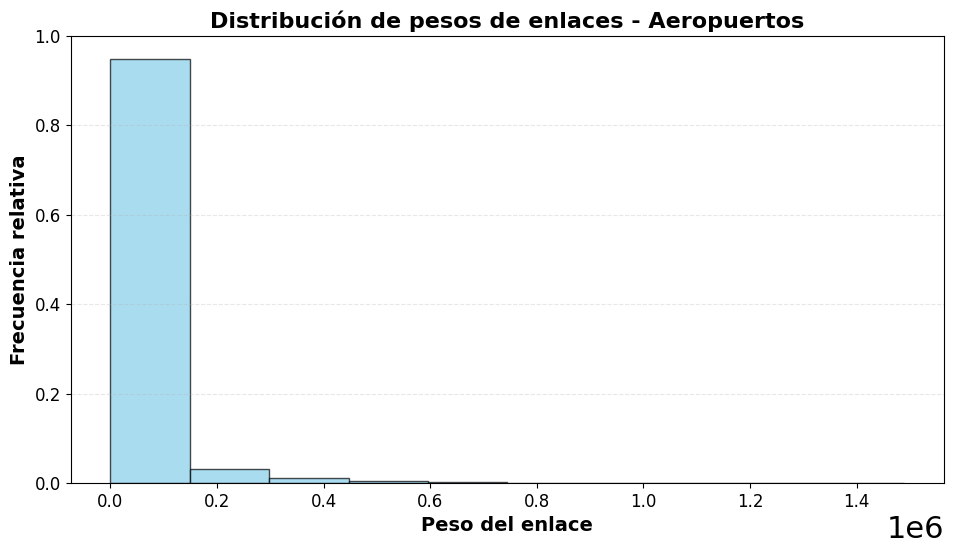

In [ ]:
# Obtener los pesos de los enlaces
edge_weights_per = nx.get_edge_attributes(air, "weight")
weights = np.array(list(edge_weights_per.values()))

# Definir el número de bins
num_bins = 10
counts, bin_edges = np.histogram(weights, bins=num_bins)

# Calcular la frecuencia relativa
relative_freq = counts / counts.sum()

# Graficar el histograma de frecuencia relativa
plt.figure(figsize=(10, 6))
plt.bar(
    bin_edges[:-1],                 # Posición de cada barra (lado izquierdo del bin)
    relative_freq,                  # Frecuencia relativa
    width=np.diff(bin_edges),       # Ancho de cada barra
    color='skyblue',
    edgecolor='black',
    alpha=0.7,
    align='edge'
)

# Etiquetas y título
plt.xlabel('Peso del enlace', fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia relativa', fontsize=14, fontweight='bold')
plt.title('Distribución de pesos de enlaces - Aeropuertos', fontsize=16, fontweight='bold')

# Ejes y cuadrícula
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 1)                     # Limitar la frecuencia relativa entre 0 y 1
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()


# Cálculo de la asortividad

In [ ]:
nx.degree_assortativity_coefficient(air), nx.degree_assortativity_coefficient(fb)

(-0.1221332905330767, 0.06357722918564943)

In [ ]:
G = fb

# Grado y promedio del grado de los vecinos
degrees = dict(G.degree())
avg_neighbor_degrees = nx.average_neighbor_degree(G)

k_vs_knn = defaultdict(list)
for node in G.nodes():
    k = degrees[node]
    k_nn = avg_neighbor_degrees[node]
    k_vs_knn[k].append(k_nn)

# Preparar datos
k_values = sorted(k_vs_knn.keys())
k_nn_values = [np.mean(k_vs_knn[k]) for k in k_values]

# Graficar con seaborn (solo puntos + línea de tendencia)
plt.figure(figsize=(8,6))
sns.regplot(x=k_values, y=k_nn_values, scatter=True, fit_reg=True, lowess=True,line_kws={"color": "red"})
plt.xlabel("Grado del nodo (k)")
plt.ylabel("Promedio del grado de los vecinos k_nn(k)")
plt.title("Asortatividad estructural - Facebook")
plt.grid(True)
plt.show()


NameError: name 'defaultdict' is not defined

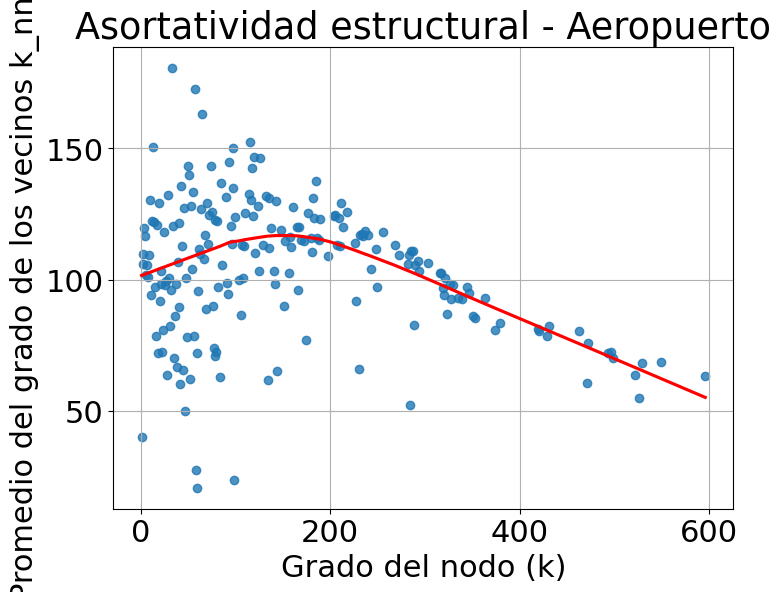

In [ ]:
G = air

# Grado y promedio del grado de los vecinos
degrees = dict(G.degree())
avg_neighbor_degrees = nx.average_neighbor_degree(G)

k_vs_knn = defaultdict(list)
for node in G.nodes():
    k = degrees[node]
    k_nn = avg_neighbor_degrees[node]
    k_vs_knn[k].append(k_nn)

# Preparar datos
k_values = sorted(k_vs_knn.keys())
k_nn_values = [np.mean(k_vs_knn[k]) for k in k_values]

# Graficar con seaborn (solo puntos + línea de tendencia)
plt.figure(figsize=(8,6))
sns.regplot(x=k_values, y=k_nn_values, scatter=True, fit_reg=True, lowess=True,line_kws={"color": "red"} )
plt.xlabel("Grado del nodo (k)")
plt.ylabel("Promedio del grado de los vecinos k_nn(k)")
plt.title("Asortatividad estructural - Aeropuerto")
plt.grid(True)
plt.show()


# Distribución simulada vs observada de métricas de red

## Distribución simulada Aeropuertos

In [ ]:
# --- Asignación de grafos reales ---
G_air = airStrongly

# --- Configuración general ---
total_repetitions = 1000            # Ajusta si necesitas más repeticiones
chunk_size = 100                    # Cada 100 simulaciones se guarda un checkpoint
output_path = '/content/drive/MyDrive/data_simulacion_airports.pkl'  # Archivo de salida específico para aeropuertos

# --- Calcular grado medio y parámetro m ---
grado_medio_air = 2 * G_air.number_of_edges() / G_air.number_of_nodes()
mcero = int(round(grado_medio_air / (2 - 1 / G_air.number_of_nodes())))

# --- Función para una simulación ---
def run_simulation(i):
    d = {}

    # Barabasi-Albert
    G = nx.barabasi_albert_graph(G_air.number_of_nodes(), mcero, seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_dist'] = nx.average_shortest_path_length(G)
    d['ba_avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([deg for _, deg in G.degree()], discrete=True, xmin=8).alpha

    # Erdos-Renyi
    G = nx.gnm_random_graph(G_air.number_of_nodes(), G_air.number_of_edges())
    d['er_avg_clus'] = nx.average_clustering(G)
    d['er_avg_dist'] = nx.average_shortest_path_length(G)
    d['er_avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()

    # Watts-Strogatz
    G = nx.watts_strogatz_graph(G_air.number_of_nodes(), int(grado_medio_air), 0.03)
    d['ws_avg_clus'] = nx.average_clustering(G)
    d['ws_avg_dist'] = nx.average_shortest_path_length(G)
    d['ws_avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()

    print(f"✅ Simulación completada: {i}")
    return d

# --- Cargar resultados existentes si existen ---
if os.path.exists(output_path):
    with open(output_path, 'rb') as f:
        data = pickle.load(f)
    repetitions_done = len(data)
    print(f"📂 Archivo encontrado: {output_path}")
    print(f"🔄 Simulaciones ya completadas: {repetitions_done}")
else:
    data = []
    repetitions_done = 0
    print("🚀 No se encontró archivo previo. Comenzando desde cero.")

remaining_repetitions = total_repetitions - repetitions_done
print(f"🎯 Simulaciones restantes: {remaining_repetitions}")

# --- Ejecutar simulaciones faltantes ---
if remaining_repetitions > 0:
    num_cpus = os.cpu_count()
    for chunk_start in range(repetitions_done, total_repetitions, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_repetitions)
        chunk_indices = range(chunk_start, chunk_end)
        print(f"💻 Simulando iteraciones {chunk_start} a {chunk_end - 1}...")

        chunk_data = Parallel(n_jobs=num_cpus)(
            delayed(run_simulation)(i) for i in tqdm(chunk_indices, desc=f"Chunk {chunk_start}-{chunk_end-1}")
        )
        data.extend(chunk_data)

        # Guardar checkpoint
        with open(output_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"💾 Guardado automático: {output_path} (simulaciones hasta {chunk_end - 1})")

    print("🏁 ¡Simulaciones completadas y guardadas!")
else:
    print("🎉 ¡Ya has completado todas las simulaciones!")





📂 Archivo encontrado: /content/drive/MyDrive/data_simulacion_airports.pkl
🔄 Simulaciones ya completadas: 1000
🎯 Simulaciones restantes: 0
🎉 ¡Ya has completado todas las simulaciones!


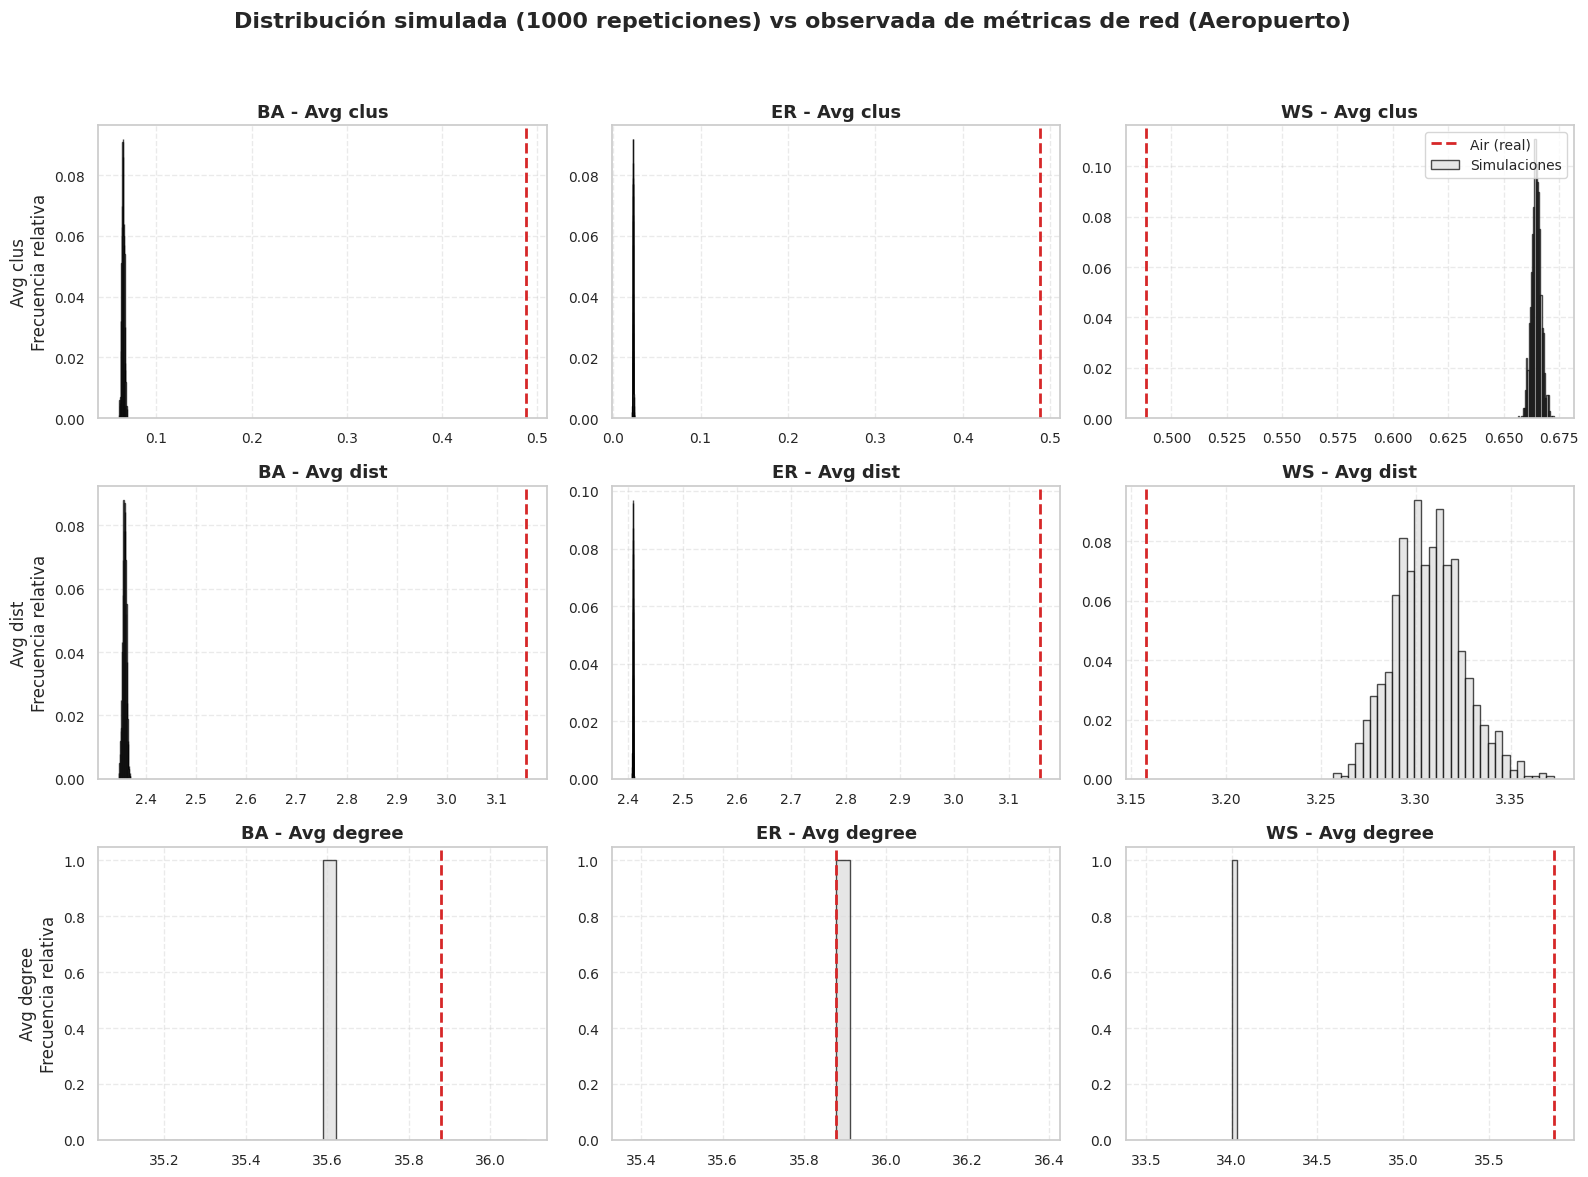

In [ ]:
# --- Convertir resultados a DataFrame ---
df = pd.DataFrame(data)

# --- Indicadores y modelos a visualizar ---
indicadores = ['avg_clus', 'avg_dist', 'avg_degree']
modelos = ['ba', 'er', 'ws']

# --- Calcular valores reales para Air ---
avg_dist_air = nx.average_shortest_path_length(G_air, weight='weight')
avg_clus_air = nx.average_clustering(G_air)

valores_reales_air = {
    'avg_clus': avg_clus_air,
    'avg_dist': avg_dist_air,
    'avg_degree': grado_medio_air
}

# --- Configuración visual general ---
sns.set(style='whitegrid')
plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Colores definidos
color_hist = '#dcdcdc'
color_air = '#d62728'  # rojo
color_fb = '#1f77b4'   # azul

# --- Visualización de histogramas ---
fig, axs = plt.subplots(len(indicadores), len(modelos), figsize=(16, 12))

for i, ind in enumerate(indicadores):
    for j, model in enumerate(modelos):
        ax = axs[i, j]
        col_name = f'{model}_{ind}'

        # Calcular histograma manualmente para frecuencia relativa
        counts, bins = np.histogram(df[col_name], bins=30)
        freq_rel = counts / counts.sum()  # proporción (suma = 1)

        # Graficar como barras
        ax.bar(bins[:-1], freq_rel, width=np.diff(bins), align='edge',
               alpha=0.7, color=color_hist, edgecolor='black', label='Simulaciones')

        # Línea: valor real de Air
        ax.axvline(valores_reales_air[ind], color=color_air,
                   linewidth=2, linestyle='--', label='Air (real)')

        # Título y ajustes estéticos
        titulo = f"{model.upper()} - {ind.replace('_', ' ').capitalize()}"
        ax.set_title(titulo, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Leyenda solo en una esquina
        if i == 0 and j == len(modelos) - 1:
            ax.legend(loc='upper right')

# Etiquetas de fila
for ax, ind in zip(axs[:, 0], indicadores):
    etiqueta = f"{ind.replace('_', ' ').capitalize()}\nFrecuencia relativa"
    ax.set_ylabel(etiqueta, fontsize=12)

# Título general
plt.suptitle("Distribución simulada (1000 repeticiones) vs observada de métricas de red (Aeropuerto)",
             fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## Distribución simulada Facebook

In [ ]:
# --- Asignación de grafos reales ---
G_fb = fb  # Asumiendo que ya cargaste tu grafo de Facebook

# --- Configuración general ---
total_repetitions = 1000          # O 1000, como prefieras
chunk_size = 100                  # Guardar cada 50 simulaciones
output_path = '/content/drive/MyDrive/data_simulacion.pkl'

# --- Calcular grado medio y parámetro m para fb ---
grado_medio_fb = 2 * G_fb.number_of_edges() / G_fb.number_of_nodes()
mcero = int(round(grado_medio_fb / (2 - 1 / G_fb.number_of_nodes())))

# --- Función para una simulación ---
def run_simulation(i):
    d = {}

    # Barabasi-Albert
    G = nx.barabasi_albert_graph(G_fb.number_of_nodes(), mcero, seed=i)
    d['ba_avg_clus'] = nx.average_clustering(G)
    d['ba_avg_dist'] = nx.average_shortest_path_length(G)
    d['ba_avg_degree'] = 2 * G.number_of_edges() / G_fb.number_of_nodes()
    d['ba_alpha'] = powerlaw.Fit([deg for _, deg in G.degree()], discrete=True, xmin=8).alpha

    # Erdos-Renyi
    G = nx.gnm_random_graph(G_fb.number_of_nodes(), G_fb.number_of_edges())
    d['er_avg_clus'] = nx.average_clustering(G)
    d['er_avg_dist'] = nx.average_shortest_path_length(G)
    d['er_avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()

    # Watts-Strogatz
    G = nx.watts_strogatz_graph(G_fb.number_of_nodes(), int(grado_medio_fb), 0.03)
    d['ws_avg_clus'] = nx.average_clustering(G)
    d['ws_avg_dist'] = nx.average_shortest_path_length(G)
    d['ws_avg_degree'] = 2 * G.number_of_edges() / G.number_of_nodes()

    print(f"Simulación completada: {i}")
    return d

# --- Cargar resultados existentes si existen ---
if os.path.exists(output_path):
    with open(output_path, 'rb') as f:
        data = pickle.load(f)
    repetitions_done = len(data)
    print(f"Archivo encontrado: {output_path}")
    print(f"Simulaciones ya completadas: {repetitions_done}")
else:
    data = []
    repetitions_done = 0
    print("No se encontró archivo previo. Comenzando desde cero.")

remaining_repetitions = total_repetitions - repetitions_done
print(f"Simulaciones restantes: {remaining_repetitions}")

# --- Ejecutar simulaciones faltantes ---
if remaining_repetitions > 0:
    num_cpus = os.cpu_count()
    for chunk_start in range(repetitions_done, total_repetitions, chunk_size):
        chunk_end = min(chunk_start + chunk_size, total_repetitions)
        chunk_indices = range(chunk_start, chunk_end)
        print(f"Simulando iteraciones {chunk_start} a {chunk_end - 1}...")

        chunk_data = Parallel(n_jobs=num_cpus)(
            delayed(run_simulation)(i) for i in tqdm(chunk_indices, desc=f"Chunk {chunk_start}-{chunk_end-1}")
        )
        data.extend(chunk_data)

        # Guardar checkpoint
        with open(output_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"Guardado automático: {output_path} (simulaciones hasta {chunk_end - 1})")

    print("¡Simulaciones completadas y guardadas!")
else:
    print("¡Ya has completado todas las simulaciones!")



Archivo encontrado: /content/drive/MyDrive/data_simulacion.pkl
Simulaciones ya completadas: 1000
Simulaciones restantes: 0
¡Ya has completado todas las simulaciones!


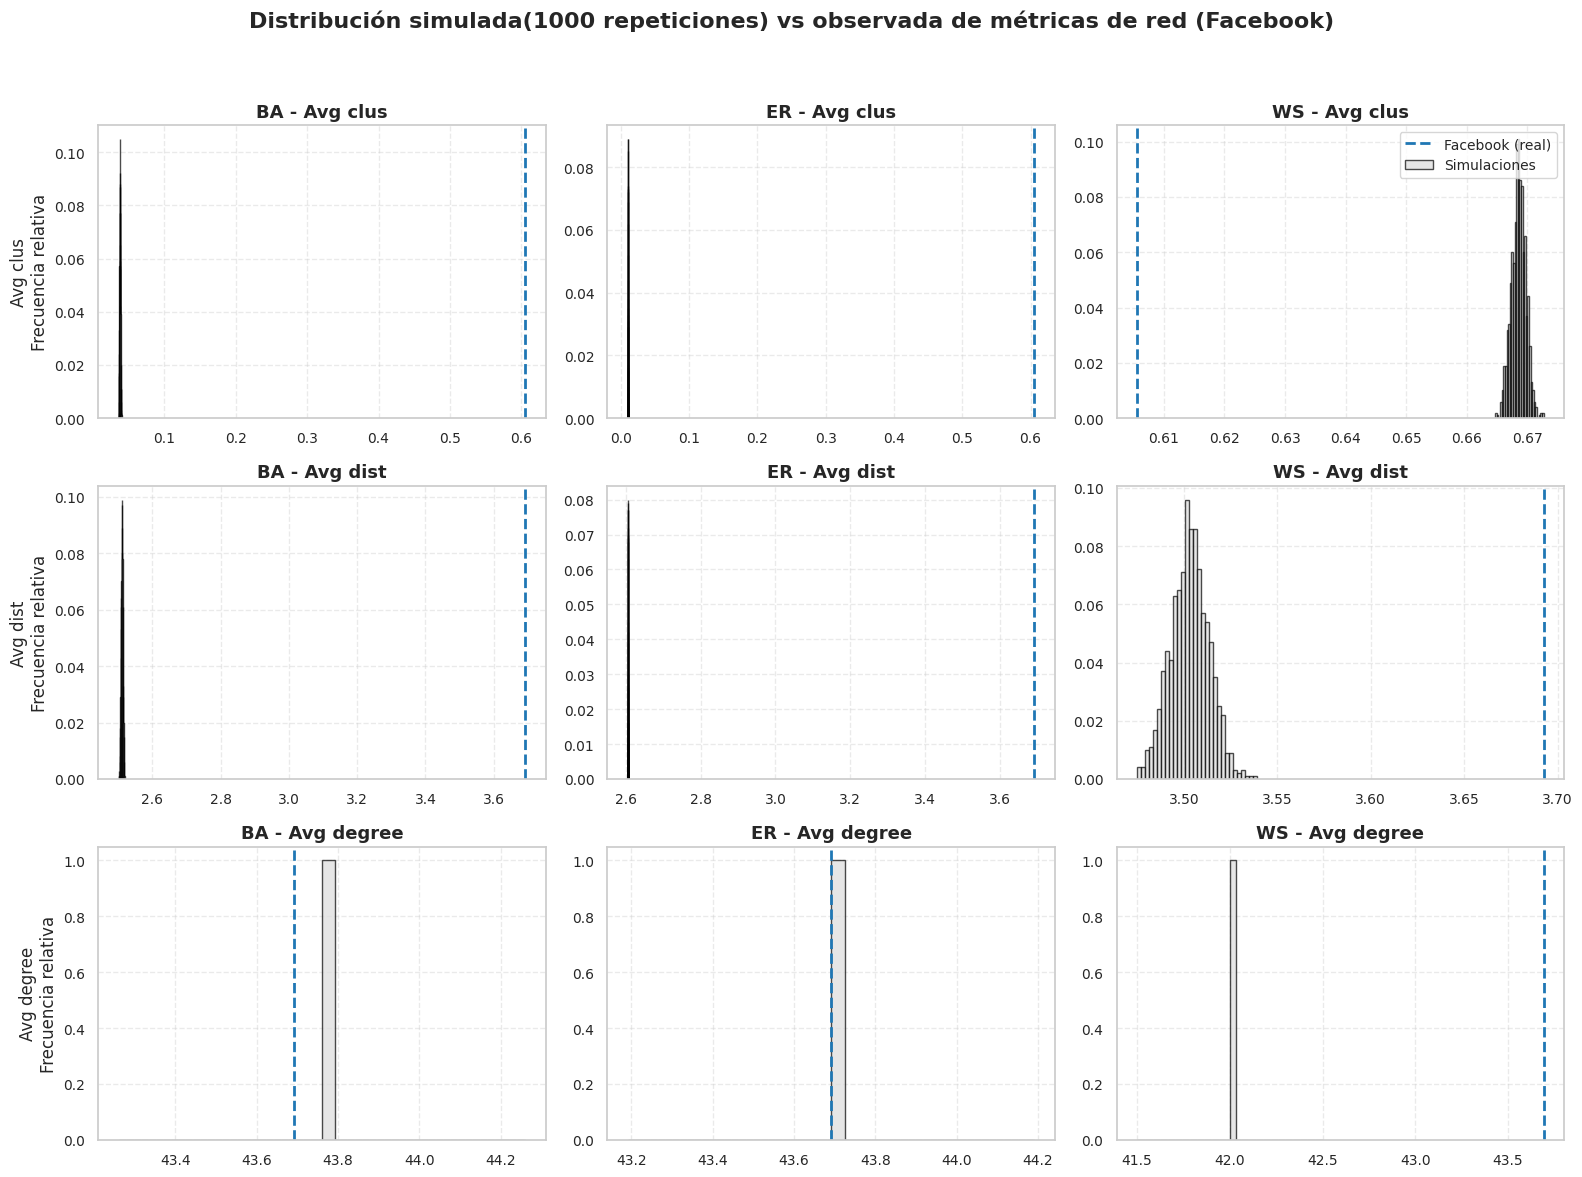

In [ ]:
# --- Convertir resultados a DataFrame ---
df = pd.DataFrame(data)

# --- Definir indicadores y modelos a visualizar ---
indicadores = ['avg_clus', 'avg_dist', 'avg_degree']
modelos = ['ba', 'er', 'ws']

# --- Calcular valores reales para Facebook ---
if G_fb.is_directed():
    if not nx.is_strongly_connected(G_fb):
        largest_scc_fb = max(nx.strongly_connected_components(G_fb), key=len)
        G_fb_sub = G_fb.subgraph(largest_scc_fb).copy()
    else:
        G_fb_sub = G_fb
    avg_dist_fb = nx.average_shortest_path_length(G_fb_sub)
else:
    if not nx.is_connected(G_fb):
        largest_cc_fb = max(nx.connected_components(G_fb), key=len)
        G_fb_sub = G_fb.subgraph(largest_cc_fb).copy()
    else:
        G_fb_sub = G_fb
    avg_dist_fb = nx.average_shortest_path_length(G_fb_sub)

# Calcular valores reales para cada indicador
valores_reales_fb = {
    'avg_clus': nx.average_clustering(G_fb),
    'avg_dist': avg_dist_fb,
    'avg_degree': 2 * G_fb.number_of_edges() / G_fb.number_of_nodes()
}

# --- Configuración visual general ---
sns.set(style='whitegrid')
plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Colores definidos
color_hist = '#dcdcdc'
color_fb = '#1f77b4'   # Azul

# --- Visualización de histogramas ---
fig, axs = plt.subplots(len(indicadores), len(modelos), figsize=(16, 12))

for i, ind in enumerate(indicadores):
    for j, model in enumerate(modelos):
        ax = axs[i, j]
        col_name = f'{model}_{ind}'

        # Calcular histograma manualmente para frecuencia relativa
        counts, bins = np.histogram(df[col_name], bins=30)
        freq_rel = counts / counts.sum()  # proporción (suma = 1)

        # Graficar como barras
        ax.bar(bins[:-1], freq_rel, width=np.diff(bins), align='edge',
               alpha=0.7, color=color_hist, edgecolor='black', label='Simulaciones')

        # Línea vertical: valor real de Facebook
        ax.axvline(valores_reales_fb[ind], color=color_fb,
                   linestyle='--', linewidth=2, label='Facebook (real)')

        # Título y estética
        titulo = f"{model.upper()} - {ind.replace('_', ' ').capitalize()}"
        ax.set_title(titulo, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.4)

        # Mostrar leyenda solo en la esquina superior derecha del último gráfico
        if i == 0 and j == len(modelos) - 1:
            ax.legend(loc='upper right')

# Etiquetas de fila para el eje Y
for ax, ind in zip(axs[:, 0], indicadores):
    etiqueta = f"{ind.replace('_', ' ').capitalize()}\nFrecuencia relativa"
    ax.set_ylabel(etiqueta, fontsize=12)

# Título general
plt.suptitle("Distribución simulada(1000 repeticiones) vs observada de métricas de red (Facebook)",
             fontsize=16, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Coeficientes de clustering de cada nodo

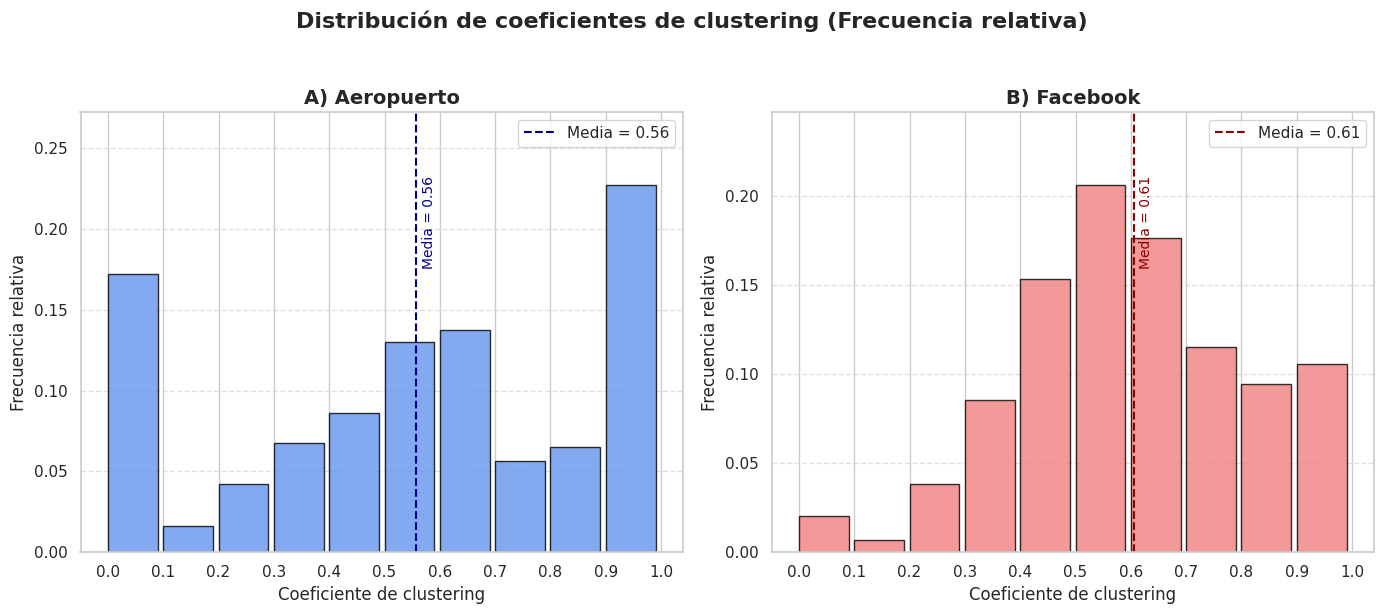

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns

# Suponiendo que 'airU' y 'fb' son grafos ya definidos
clustering_air = list(nx.clustering(airU).values())
clustering_fb = list(nx.clustering(fb).values())

# Definir bins
bins = np.arange(0, 1.1, 0.1)  # de 0 a 1.0 con paso 0.1

# Crear la figura
plt.figure(figsize=(14, 6))

# Configuración general de estilos
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# --- Aeropuerto ---
plt.subplot(1, 2, 1)
counts_air, bin_edges_air = np.histogram(clustering_air, bins=bins)
proportions_air = counts_air / counts_air.sum()

# Barras
plt.bar(bin_edges_air[:-1], proportions_air,
        width=0.09, color='cornflowerblue', edgecolor='black', alpha=0.8, align='edge')

# Añadir media y desviación estándar
mean_air = np.mean(clustering_air)
std_air = np.std(clustering_air)
plt.axvline(mean_air, color='darkblue', linestyle='--', label=f'Media = {mean_air:.2f}')
plt.text(mean_air+0.01, max(proportions_air)*0.9, f'Media = {mean_air:.2f}',
         rotation=90, va='center', fontsize=10, color='darkblue')

# Etiquetas
plt.title('A) Aeropuerto', fontsize=14, fontweight='bold')
plt.xlabel('Coeficiente de clustering')
plt.ylabel('Frecuencia relativa')
plt.ylim(0, max(proportions_air)*1.2)
plt.xticks(bins)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# --- Facebook ---
plt.subplot(1, 2, 2)
counts_fb, bin_edges_fb = np.histogram(clustering_fb, bins=bins)
proportions_fb = counts_fb / counts_fb.sum()

# Barras
plt.bar(bin_edges_fb[:-1], proportions_fb,
        width=0.09, color='lightcoral', edgecolor='black', alpha=0.8, align='edge')

# Media y desviación estándar
mean_fb = np.mean(clustering_fb)
std_fb = np.std(clustering_fb)
plt.axvline(mean_fb, color='darkred', linestyle='--', label=f'Media = {mean_fb:.2f}')
plt.text(mean_fb+0.01, max(proportions_fb)*0.9, f'Media = {mean_fb:.2f}',
         rotation=90, va='center', fontsize=10, color='darkred')

# Etiquetas
plt.title('B) Facebook', fontsize=14, fontweight='bold')
plt.xlabel('Coeficiente de clustering')
plt.ylabel('Frecuencia relativa')
plt.ylim(0, max(proportions_fb)*1.2)
plt.xticks(bins)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Título global
plt.suptitle('Distribución de coeficientes de clustering (Frecuencia relativa)',
             fontsize=16, fontweight='bold', y=1.02)

# Ajustar espacio
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()


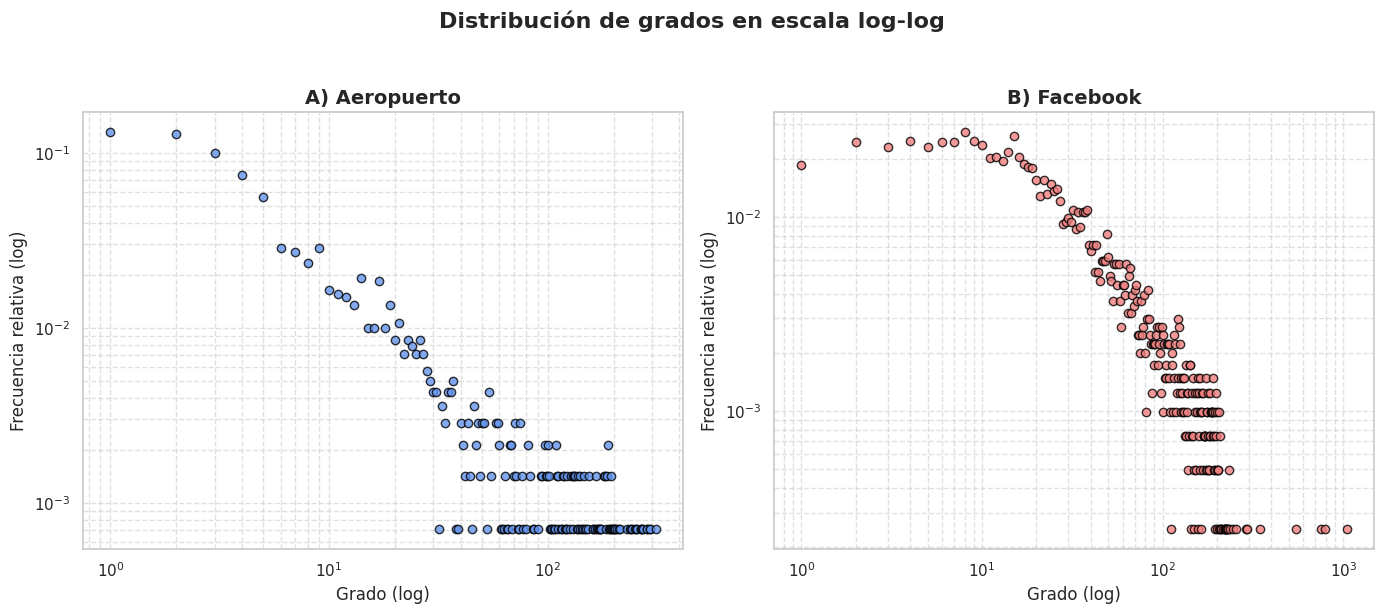

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from collections import Counter

# Calcular grados
degrees_air = [deg for _, deg in airU.degree()]
degrees_fb = [deg for _, deg in fb.degree()]

# Distribución de grados (contador)
degree_counts_air = Counter(degrees_air)
degree_counts_fb = Counter(degrees_fb)

# Ordenar por grado
deg_air, count_air = zip(*sorted(degree_counts_air.items()))
deg_fb, count_fb = zip(*sorted(degree_counts_fb.items()))

# Normalizar a frecuencia relativa
proportion_air = np.array(count_air) / sum(count_air)
proportion_fb = np.array(count_fb) / sum(count_fb)

# Graficar log-log
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Aeropuerto
plt.subplot(1, 2, 1)
plt.scatter(deg_air, proportion_air, color='cornflowerblue', edgecolor='black', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grado (log)')
plt.ylabel('Frecuencia relativa (log)')
plt.title('A) Aeropuerto', fontsize=14, fontweight='bold')
plt.grid(which='both', linestyle='--', alpha=0.6)

# Facebook
plt.subplot(1, 2, 2)
plt.scatter(deg_fb, proportion_fb, color='lightcoral', edgecolor='black', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grado (log)')
plt.ylabel('Frecuencia relativa (log)')
plt.title('B) Facebook', fontsize=14, fontweight='bold')
plt.grid(which='both', linestyle='--', alpha=0.6)

plt.suptitle('Distribución de grados en escala log-log', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


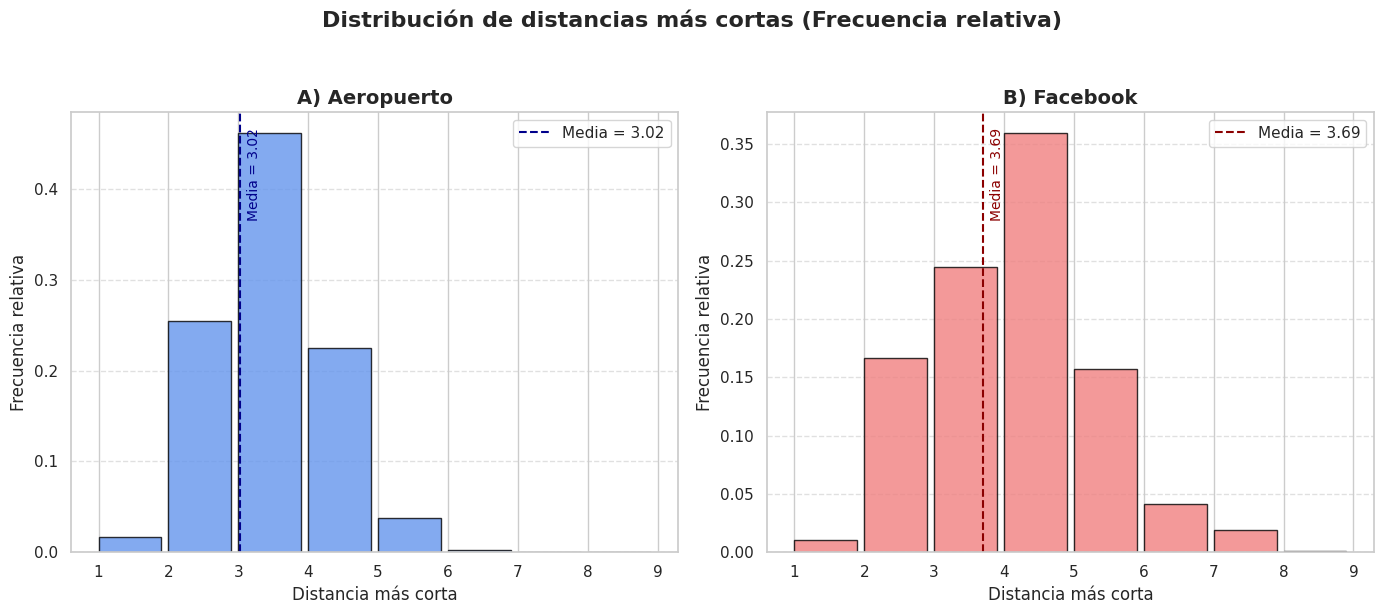

In [ ]:
# Distancias más cortas
lengths_air = []
for source, lengths in nx.all_pairs_shortest_path_length(airU):
    lengths_air.extend([l for target, l in lengths.items() if source != target])

lengths_fb = []
for source, lengths in nx.all_pairs_shortest_path_length(fb):
    lengths_fb.extend([l for target, l in lengths.items() if source != target])

# Bins para el histograma
bins_dist = np.arange(1, max(max(lengths_air), max(lengths_fb)) + 2, 1)

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})

# Aeropuerto
plt.subplot(1, 2, 1)
counts_air, bin_edges_air = np.histogram(lengths_air, bins=bins_dist)
proportions_air = counts_air / counts_air.sum()
plt.bar(bin_edges_air[:-1], proportions_air,
        width=0.9, color='cornflowerblue', edgecolor='black', alpha=0.8, align='edge')

mean_air = np.mean(lengths_air)
plt.axvline(mean_air, color='darkblue', linestyle='--', label=f'Media = {mean_air:.2f}')
plt.text(mean_air+0.1, max(proportions_air)*0.9, f'Media = {mean_air:.2f}',
         rotation=90, va='center', fontsize=10, color='darkblue')

plt.title('A) Aeropuerto', fontsize=14, fontweight='bold')
plt.xlabel('Distancia más corta')
plt.ylabel('Frecuencia relativa')
plt.xticks(bins_dist)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Facebook
plt.subplot(1, 2, 2)
counts_fb, bin_edges_fb = np.histogram(lengths_fb, bins=bins_dist)
proportions_fb = counts_fb / counts_fb.sum()
plt.bar(bin_edges_fb[:-1], proportions_fb,
        width=0.9, color='lightcoral', edgecolor='black', alpha=0.8, align='edge')

mean_fb = np.mean(lengths_fb)
plt.axvline(mean_fb, color='darkred', linestyle='--', label=f'Media = {mean_fb:.2f}')
plt.text(mean_fb+0.1, max(proportions_fb)*0.9, f'Media = {mean_fb:.2f}',
         rotation=90, va='center', fontsize=10, color='darkred')

plt.title('B) Facebook', fontsize=14, fontweight='bold')
plt.xlabel('Distancia más corta')
plt.ylabel('Frecuencia relativa')
plt.xticks(bins_dist)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Distribución de distancias más cortas (Frecuencia relativa)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


**Componente Fuertemente Conexa (Strongly Connected):**

1.   Desde cada nodo de la componente existe un camino hacia todos los otros nodos que usa aristas únicamente de la componente.
2.   No hay un nodo del grafo fuera de la componente desde el cual se pueda llegar a la componente y al que se pueda llegar desde ella (si existiera estaría en la componente).

**Componente Débilmente Conexa (Weakly Connected):**


1.  Si al convertir el grafo dirigido en uno no dirigido el grafo resultante es conexo.
**¿Cómo medir distancias en grafos dirigidos?**

1.   Si es un componente fuertemente conexo puedo medir $<d>$ normalmente (con nx.average_shortest_path_length o con estimate_path_length si el grafo es muy grande)
2.   Si es un componente debilmente conexo no puedo medir $<d>$. Primero debo transformar el componente a un grafo no dirigido (con nx.DiGraph.to_undirected) y ahí si medir $<d>$. Pero tomar en cuenta que vamos a haber perdido la información de la direccionalidad.

Observación: para grafos dirigidos la eficiencia global $eff$ (nx.global_efficiency) no está definida.






##Componentes de la red dirigida Airport

In [ ]:
airStronglyCC = sorted(nx.strongly_connected_components(air), key=len, reverse=True)
airStrongly = air.subgraph(airStronglyCC[0]) # la mas grande en 0 y así en orden
print('Airport componente gigante fuertemente conexa')
print(airStrongly)
print('Es dirigido?:',nx.is_directed(airStrongly))
print('Es pesado?:',nx.is_weighted(airStrongly))
print('Es fuertemente conexo?:',nx.is_strongly_connected(airStrongly))
print('Es debilmente conexo?:',nx.is_weakly_connected(airStrongly))
print('')

Airport componente gigante fuertemente conexa
DiGraph with 1402 nodes and 28032 edges
Es dirigido?: True
Es pesado?: True
Es fuertemente conexo?: True
Es debilmente conexo?: True



##Componente gigante de Airport

In [ ]:
airUndir=nx.DiGraph.to_undirected(airStrongly)
airU = airUndir.copy()
drop_weights(airU)
print('C. air (unweighted)')
print(airU)
print('Es dirigido?:',nx.is_directed(airU))
print('Es pesado?:',nx.is_weighted(airU))
print('Es conectado?:',nx.is_connected(airU))
print('')

C. air (unweighted)
Graph with 1402 nodes and 17013 edges
Es dirigido?: False
Es pesado?: False
Es conectado?: True



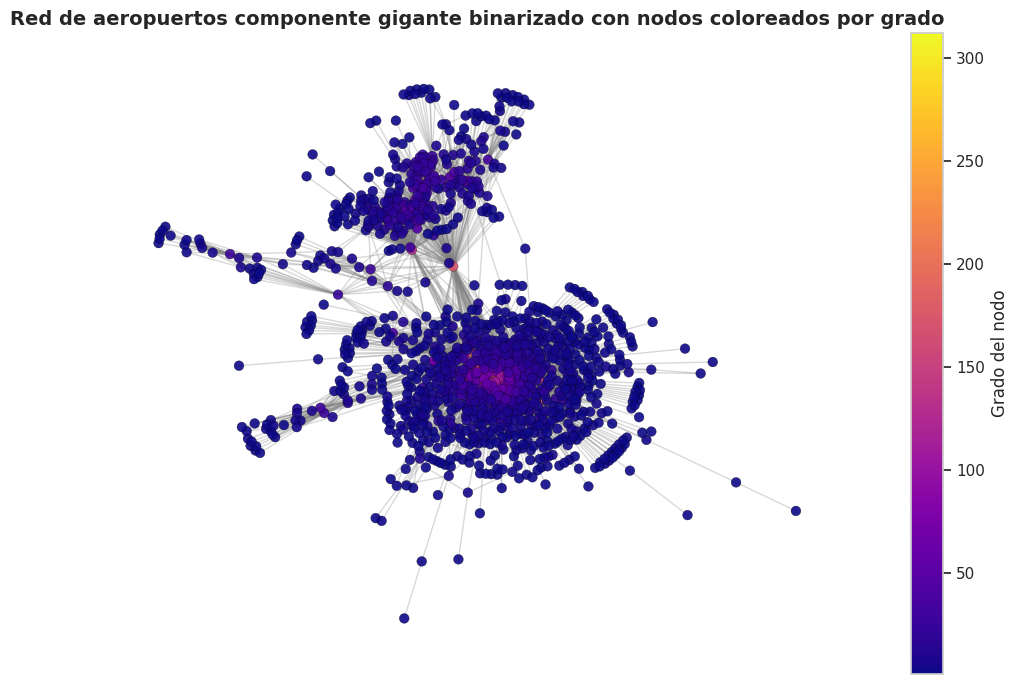

In [ ]:
G =airU
# Grado
degrees = dict(G.degree())
n_color = np.array([degrees[n] for n in G.nodes()])

# Layout
layout = nx.spring_layout(G, iterations=1000)

# Colores
vmin = n_color.min()
vmax = n_color.max()

# Usamos una paleta moderna y perceptualmente uniforme
cmap = plt.cm.plasma
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Figura
plt.figure(figsize=(10, 7))
plt.title('Red de aeropuertos componente gigante binarizado con nodos coloreados por grado', fontsize=14, fontweight='bold')

# Dibujo de nodos y aristas (no quité nada)
nx.draw_networkx_edges(G, layout, alpha=0.3, edge_color='gray')
nodes = nx.draw_networkx_nodes(G, layout,
                               node_size=50,
                               node_color=n_color,
                               cmap=cmap,
                               vmin=vmin,
                               vmax=vmax,
                               alpha=0.9,
                               edgecolors='black',
                               linewidths=0.2)

# Barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Grado del nodo', fontsize=12)

# Ajustes finales
plt.axis('off')
plt.tight_layout()
plt.show()




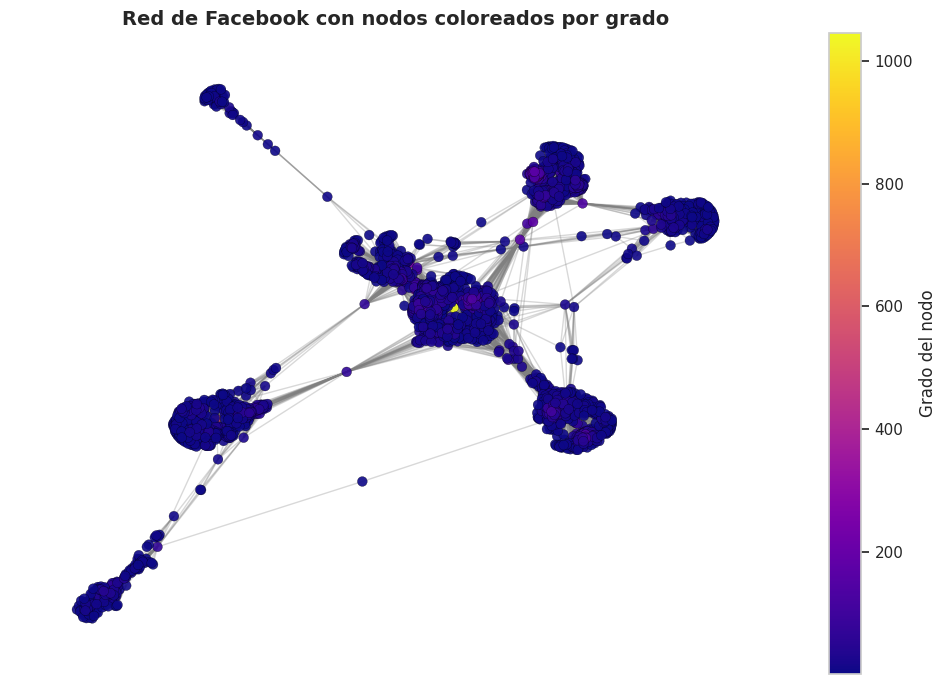

In [ ]:
G = fb  # Asegúrate de que 'fb' está definido

# Grado
degrees = dict(G.degree())
n_color = np.array([degrees[n] for n in G.nodes()])

# Layout
layout = nx.spring_layout(G, iterations=1000)

# Colores
vmin = n_color.min()
vmax = n_color.max()

# Usamos la paleta plasma
cmap = plt.cm.plasma
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# Figura
plt.figure(figsize=(10, 7))
plt.title('Red de Facebook con nodos coloreados por grado', fontsize=14, fontweight='bold')

# Dibujo de nodos y aristas
nx.draw_networkx_edges(G, layout, alpha=0.3, edge_color='gray')
nodes = nx.draw_networkx_nodes(G, layout,
                               node_size=50,
                               node_color=n_color,
                               cmap=cmap,
                               vmin=vmin,
                               vmax=vmax,
                               alpha=0.9,
                               edgecolors='black',
                               linewidths=0.2)

# Barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.set_label('Grado del nodo', fontsize=12)

# Ajustes finales
plt.axis('off')
plt.tight_layout()
plt.show()


# Small World - Histograma de distancias geodésicas

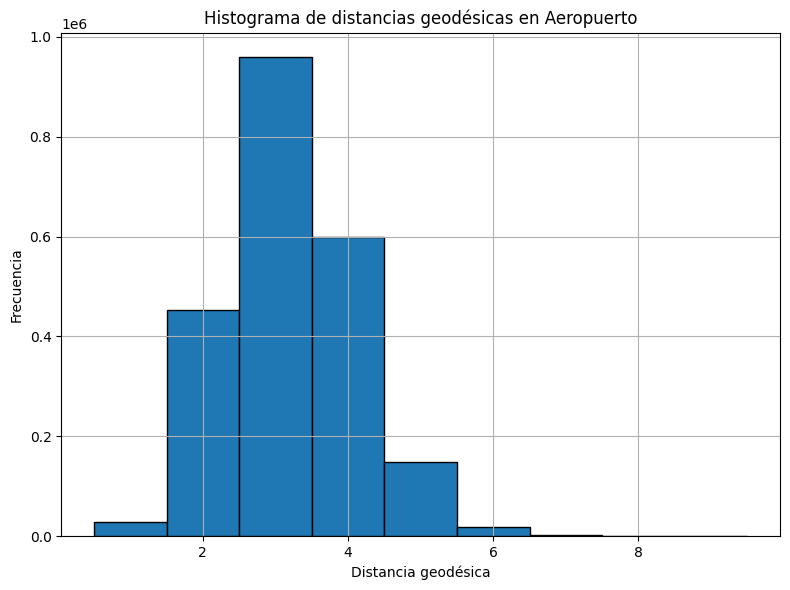

In [ ]:

G = air

# Verificar si el grafo es dirigido
if G.is_directed():
    # Componente débilmente conexo más grande
    G_largest = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()
else:
    # Componente conexo más grande
    G_largest = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Calcular todas las distancias geodésicas (caminos más cortos)
lengths = dict(nx.all_pairs_shortest_path_length(G_largest))

# Extraer distancias en una lista
distancias = []
for source in lengths:
    for target in lengths[source]:
        if source != target:
            distancias.append(lengths[source][target])

# Graficar histograma
plt.figure(figsize=(8,6))
plt.hist(distancias, bins=range(1, max(distancias)+2), edgecolor='black', align='left')
plt.xlabel("Distancia geodésica")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancias geodésicas en Aeropuerto")
plt.grid(True)
plt.tight_layout()
plt.show()


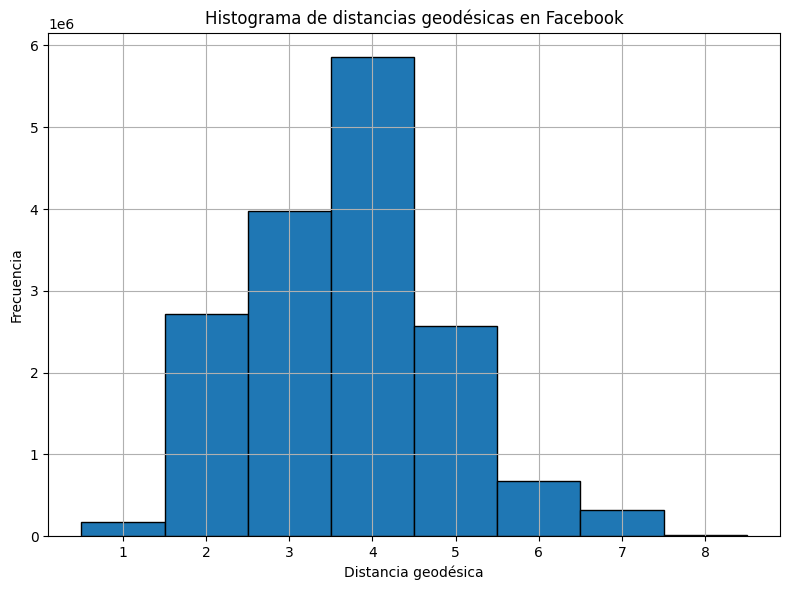

In [ ]:


G = fb

# Verificar si el grafo es dirigido
if G.is_directed():
    # Componente débilmente conexo más grande
    G_largest = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()
else:
    # Componente conexo más grande
    G_largest = G.subgraph(max(nx.connected_components(G), key=len)).copy()

# Calcular todas las distancias geodésicas (caminos más cortos)
lengths = dict(nx.all_pairs_shortest_path_length(G_largest))

# Extraer distancias en una lista
distancias = []
for source in lengths:
    for target in lengths[source]:
        if source != target:
            distancias.append(lengths[source][target])

# Graficar histograma
plt.figure(figsize=(8,6))
plt.hist(distancias, bins=range(1, max(distancias)+2), edgecolor='black', align='left')
plt.xlabel("Distancia geodésica")
plt.ylabel("Frecuencia")
plt.title("Histograma de distancias geodésicas en Facebook")
plt.grid(True)
plt.tight_layout()
plt.show()

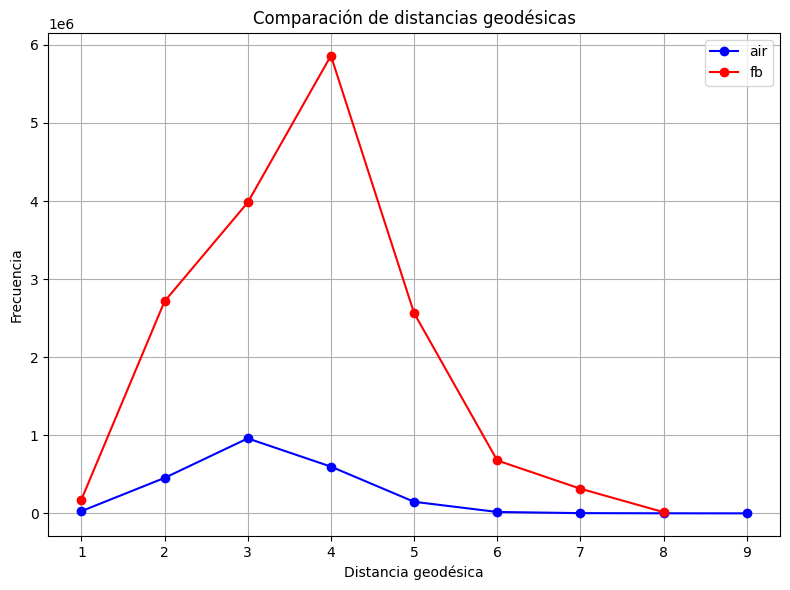

In [ ]:
def obtener_distancias(G):
    if G.is_directed():
        G = G.subgraph(max(nx.weakly_connected_components(G), key=len)).copy()
    else:
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    lengths = dict(nx.all_pairs_shortest_path_length(G))
    distancias = []
    for source in lengths:
        for target in lengths[source]:
            if source != target:
                distancias.append(lengths[source][target])
    return distancias

# Obtener distancias
dist_air = obtener_distancias(air)
dist_fb = obtener_distancias(fb)

# Contar frecuencias
freq_air = Counter(dist_air)
freq_fb = Counter(dist_fb)

# Ordenar
x_air = sorted(freq_air)
y_air = [freq_air[d] for d in x_air]

x_fb = sorted(freq_fb)
y_fb = [freq_fb[d] for d in x_fb]

# Graficar líneas
plt.figure(figsize=(8,6))
plt.plot(x_air, y_air, marker='o', linestyle='-', label='air', color='blue')
plt.plot(x_fb, y_fb, marker='o', linestyle='-', label='fb', color='red')

plt.xlabel("Distancia geodésica")
plt.ylabel("Frecuencia")
plt.title("Comparación de distancias geodésicas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Spring Layout: posición espacial de los nodos en el grafo
*Uso posiciones on pre-computadas (con $iterations$=1000 y $k$=None)*

In [ ]:

pos_fb=get_graph_pos('fb_pos.pkl')
pos_airSC=get_graph_pos('airportStronglyConn_pos.pkl')

In [ ]:

def plotWeightedGraph1(G,pos,colorMapping,magnification,nodeSize=45):
  values = [v for n,v in colorMapping.items()]
  nx.draw_networkx_nodes(G,pos=pos,node_size=nodeSize, node_color = values)
  nx.draw_networkx_labels(G,pos,{n:n for n in G.nodes()},font_size=7,font_color='white')

  edge_weights = nx.get_edge_attributes(G, "weight")
  edgeWidths=np.array(list(edge_weights.values()))
  edgeWidths=magnification*edgeWidths/np.max(edgeWidths)
  edgeWidths[edgeWidths>0]=edgeWidths[edgeWidths>0]-np.min(edgeWidths[edgeWidths>0])+.5

  nx.draw_networkx_edges(G, pos, edgelist=G.edges(),width=edgeWidths,edge_color='gray')


In [ ]:
def plotWeightedGraph2(
    G, pos, attribute,
    exaggeration=100,
    base_node_size=50,
    edge_magnification=2,
    top_k_labels=10,
    cmap=plt.cm.plasma
):
    """
    Visualiza un grafo ponderado:
    - Tamaño y color de nodos según 'attribute' (ej: centralidad), con escala robusta
    - Grosor de aristas según pesos
    - Muestra etiquetas de los top_k_labels nodos más importantes
    - Paleta de colores configurable (cmap)
    """

    plt.figure(figsize=(6, 6))

    # Escalar valores del atributo
    values = np.array([attribute.get(n, 0) for n in G.nodes()])
    if np.max(values) != np.min(values):
        scaled_sizes = exaggeration * (values - np.min(values)) / (np.max(values) - np.min(values)) + base_node_size
    else:
        scaled_sizes = np.full_like(values, base_node_size)

    # Dibujar nodos
    nx.draw_networkx_nodes(
        G, pos=pos,
        node_size=scaled_sizes,
        node_color=values,
        cmap=cmap,
        edgecolors='white',
        linewidths=1.2,
        alpha=0.9
    )

    # Dibujar aristas con grosor según pesos
    edge_weights = nx.get_edge_attributes(G, "weight")
    raw_weights = np.array(list(edge_weights.values()))
    if np.max(raw_weights) > 0:
        scaled_widths = edge_magnification * (raw_weights / np.max(raw_weights))
        scaled_widths = scaled_widths - np.min(scaled_widths) + 0.5
    else:
        scaled_widths = np.full_like(raw_weights, 0.5)

    nx.draw_networkx_edges(
        G, pos=pos,
        edgelist=list(edge_weights.keys()),
        width=scaled_widths,
        edge_color='gray',
        alpha=0.5
    )

    # Etiquetas top-k
    if top_k_labels > 0:
        top_nodes = sorted(attribute.items(), key=lambda x: x[1], reverse=True)[:top_k_labels]
        labels = {n: str(n) for n, _ in top_nodes}
        nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color='black')

    plt.axis('off')
    plt.title("Red de Aeropuertos", fontsize=14)
    plt.show()



In [ ]:
centrality = nx.degree_centrality(airStrongly)  # O cualquier métrica de nodos


In [ ]:
plotWeightedGraph2(
    airStrongly, pos_airSC,
    attribute=centrality,
    exaggeration=300,
    base_node_size=40,
    edge_magnification=3,
    top_k_labels=0,
    cmap=plt.cm.viridis            # o plasma, inferno, coolwarm, etc.
)

KeyboardInterrupt: 

In [ ]:
print(min(centrality.values()), max(centrality.values()))



0.0014275517487508922 0.42398286937901497


In [ ]:
def plotWeightedGraph_topCentral(G, pos, colorMapping, magnification=1, nodeSize=60, top_percent=6):
  # Centralidad y umbral
  values_full = np.array([colorMapping[n] for n in G.nodes()])
  threshold = np.percentile(values_full, 100 - top_percent)
  top_nodes = [n for n in G.nodes() if colorMapping[n] >= threshold]
  subG = G.subgraph(top_nodes)

  values = np.array([colorMapping[n] for n in subG.nodes()])
  vmin = np.min(values)
  vmax = np.max(values)

  fig, ax = plt.subplots(figsize=(10, 10))
  cmap = plt.cm.viridis

  # Mismo layout original para todos
  nx.draw_networkx_nodes(
      subG,
      pos=pos,
      node_size=nodeSize,
      node_color=values,
      cmap=cmap,
      vmin=vmin,
      vmax=vmax,
      ax=ax
  )

  #nx.draw_networkx_labels(subG, pos=pos, font_size=8, font_color='white', ax=ax)

  edge_weights = nx.get_edge_attributes(subG, "weight")
  if edge_weights:
      edgeWidths = np.array(list(edge_weights.values()))
      edgeWidths = magnification * edgeWidths / np.max(edgeWidths)
      if np.any(edgeWidths > 0):
          edgeWidths[edgeWidths > 0] = edgeWidths[edgeWidths > 0] - np.min(edgeWidths[edgeWidths > 0]) + 0.5
      nx.draw_networkx_edges(subG, pos, edgelist=subG.edges(), width=edgeWidths, edge_color='gray', ax=ax)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(vmin=vmin, vmax=vmax))
  sm.set_array([])
  fig.colorbar(sm, ax=ax, label='Centralidad')

  ax.set_axis_off()
  plt.title(f"Top {top_percent}% de nodos más centrales", fontsize=14)
  plt.show()
  plotWeightedGraph_topCentral(airStrongly, pos_airSC, centrality, nodeSize)

NameError: name 'nodeSize' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import networkx as nx

def plotWeightedGraph8_rescaled(G, pos, colorMapping, magnification, nodeSize=45):
    values = np.array([colorMapping[n] for n in G.nodes()])

    # Recorte inferior y superior para el color
    vmin = np.percentile(values, 5)
    vmax = np.percentile(values, 99)

    fig, ax = plt.subplots(figsize=(6, 6))
    cmap = plt.cm.viridis

    nodes = nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_size=nodeSize,
        node_color=values,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        ax=ax
    )

    #nx.draw_networkx_labels(G, pos, {n: n for n in G.nodes()}, font_size=7, font_color='white', ax=ax)

    edge_weights = nx.get_edge_attributes(G, "weight")
    edgeWidths = np.array(list(edge_weights.values()))
    edgeWidths = magnification * edgeWidths / np.max(edgeWidths)
    if np.any(edgeWidths > 0):
        edgeWidths[edgeWidths > 0] = edgeWidths[edgeWidths > 0] - np.min(edgeWidths[edgeWidths > 0]) + 0.5

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edgeWidths, edge_color='gray', ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, label='Centralidad (recortada)')

    ax.set_axis_off()
    plt.title("Centralidad rescalada de todos los nodos", fontsize=14)
    plt.show()



plotWeightedGraph8_rescaled(airStrongly, pos_airSC, centrality, magnification=100, nodeSize=60)


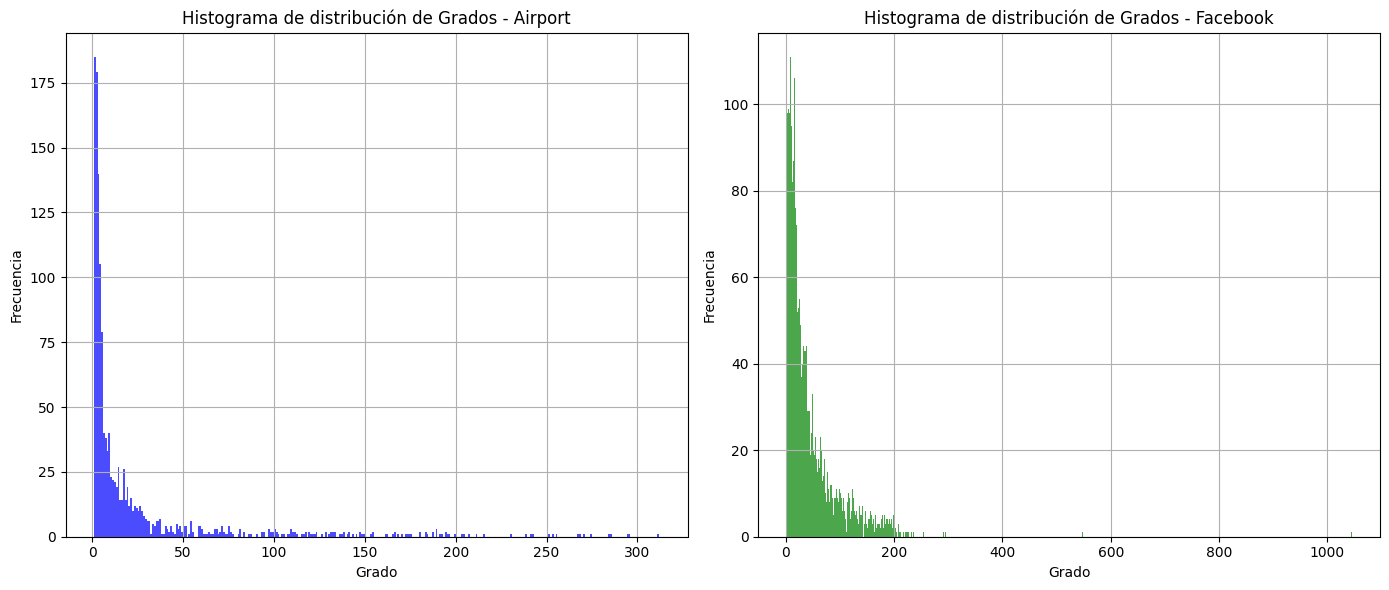

In [ ]:
# Calculo grados
degrees_air = [degree for node, degree in airU.degree()]
degrees_fac = [degree for node, degree in fb.degree()]

# Histogramas de la distribución de grados
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(degrees_air, bins=range(1, max(degrees_air)+1), color='blue', alpha=0.7)
plt.title('Histograma de distribución de Grados - Airport')
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(degrees_fac, bins=range(1, max(degrees_fac)+1), color='green', alpha=0.7)
plt.title('Histograma de distribución de Grados - Facebook')
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

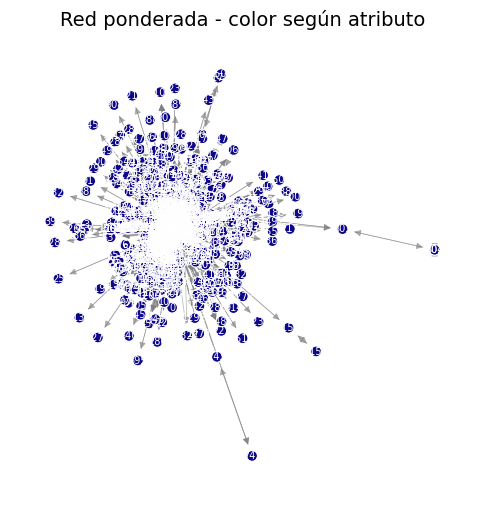

In [ ]:
def plotWeightedGraph8(G, pos, colorMapping, magnification, nodeSize=45, cmap=plt.cm.plasma):
    """
    Visualiza un grafo ponderado:
    - Nodos coloreados según un valor (por ejemplo, centralidad)
    - Tamaño fijo de nodos (se puede parametrizar)
    - Grosor de aristas según peso y magnificación
    """

    plt.figure(figsize=(6, 6))  # Crear figura

    # Obtener valores del color mapping (por ejemplo, centralidad)
    values = np.array([colorMapping.get(n, 0) for n in G.nodes()])

    # Dibujar nodos con color
    nx.draw_networkx_nodes(
        G,
        pos=pos,
        node_size=nodeSize,
        node_color=values,
        cmap=cmap,
        edgecolors='white',
        linewidths=0.8
    )

    # Dibujar etiquetas en los nodos
    nx.draw_networkx_labels(
        G,
        pos,
        labels={n: n for n in G.nodes()},
        font_size=7,
        font_color='white'
    )

    # Dibujar aristas con grosor proporcional al peso
    edge_weights = nx.get_edge_attributes(G, "weight")
    edgeWidths = np.array(list(edge_weights.values()))
    if np.max(edgeWidths) > 0:
        edgeWidths = magnification * edgeWidths / np.max(edgeWidths)
        edgeWidths = edgeWidths - np.min(edgeWidths) + 0.5
    else:
        edgeWidths = np.full_like(edgeWidths, 0.5)

    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=G.edges(),
        width=edgeWidths,
        edge_color='gray',
        alpha=0.6
    )

    plt.title("Red ponderada - color según atributo", fontsize=14)
    plt.axis('off')
    plt.show()
G=airStrongly
centrality = nx.degree_centrality(G)
magnification=1
nodeSize=60
plotWeightedGraph8(G,pos_airSC,centrality,magnification,nodeSize)

In [ ]:
def plotWeightedGraph9(G, pos, colorMapping, magnification, nodeSize=45, cmap=plt.cm.plasma):
    values = np.array([v for n, v in colorMapping.items()])

    plt.figure(figsize=(6, 6))

    # Nodos coloreados con mapa continuo
    nx.draw_networkx_nodes(
        G, pos=pos,
        node_size=nodeSize,
        node_color=values,
        cmap=cmap,
        edgecolors='black',
        linewidths=0.5,
        alpha=0.8
    )

    nx.draw_networkx_labels(G, pos, {n: n for n in G.nodes()}, font_size=7, font_color='white')

    # Aristas ponderadas
    edge_weights = nx.get_edge_attributes(G, "weight")
    edgeWidths = np.array(list(edge_weights.values()))
    edgeWidths = magnification * edgeWidths / np.max(edgeWidths)
    edgeWidths[edgeWidths > 0] = edgeWidths[edgeWidths > 0] - np.min(edgeWidths[edgeWidths > 0]) + 0.5

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edgeWidths, edge_color='gray', alpha=0.5)

    plt.axis('off')
    plt.title("Red con pesos y atributo por color", fontsize=12)
    plt.show()

G=airStrongly
centrality = nx.degree_centrality(G)
magnification=1
nodeSize=60
plotWeightedGraph9(airStrongly,pos_airSC,centrality,magnification,nodeSize)

In [ ]:
G_air =  airU.copy()
G_fac =  fb.copy()

In [ ]:
def plotNodeAttribute(G,pos,attribute,exaggeration):
  values = [v for n,v in attribute.items()]
  nsize = np.array (values)
  nsize = exaggeration*( nsize - min(nsize))/(max(nsize) - min(nsize))
  nx.draw(G,pos=pos, node_size = nsize, alpha=0.4,node_color = values, edge_color='gray')

In [ ]:
G_air =  airU.copy()
G_fac =  fb.copy()


# Parámetros para Airport
n_air = 1574
m_air = 28236
p_air = m_air / (n_air * (n_air - 1) / 2)  # Probabilidad para Erdös-Rényi

# Parámetros para Facebook
n_fac = 4039
m_fac = 88234
p_fac = m_fac / (n_fac * (n_fac - 1) / 2)  # Probabilidad para Erdös-Rényi

# Generar Erdös-Rényi
G_er_air = nx.erdos_renyi_graph(n_air, p_air)
G_er_fac = nx.erdos_renyi_graph(n_fac, p_fac)

# Generar Watts-Strogatz
k = int(2 * m_air / n_air)  # Aproximadamente el mismo grado medio
G_ws_air = nx.watts_strogatz_graph(n_air, k, p_air)
G_ws_fac = nx.watts_strogatz_graph(n_fac, k, p_fac)

# Generar Barabási-Albert
G_ba_air = nx.barabasi_albert_graph(n_air, k // 2)
G_ba_fac = nx.barabasi_albert_graph(n_fac, k // 2)

In [ ]:
def plot_degree_distribution(G, title):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=max(degrees), alpha=0.5, label=title)

def compute_metrics(G):
    clustering = nx.average_clustering(G)
    if nx.is_connected(G):
        path_length = nx.average_shortest_path_length(G)
    else:
        path_length = None
    return clustering, path_length

In [ ]:
plot_degree_distribution(G_air, "Airport")
plot_degree_distribution(G_er_air, "Erdös-Rényi Airport")
plot_degree_distribution(G_ws_air, "Watts-Strogatz Airport")
plot_degree_distribution(G_ba_air, "Barabási-Albert Airport")
plt.legend()
plt.title("Distribución de Grado")
plt.show()

for G in [G_air, G_er_air, G_ws_air, G_ba_air]:
    clustering, path_length = compute_metrics(G)
    print(f"Clustering: {clustering}, Path Length: {path_length if path_length else 'N/A'}")

In [ ]:
plot_degree_distribution(G_fac, "Facebook")
plot_degree_distribution(G_er_fac, "Erdös-Rényi Facebook")
plot_degree_distribution(G_ws_fac, "Watts-Strogatz Facebook")
plot_degree_distribution(G_ba_fac, "Barabási-Albert Facebook")
plt.legend()
plt.title("Distribución de Grado")
plt.show()


for G in [G_fac, G_er_fac, G_ws_fac, G_ba_fac]:
    clustering, path_length = compute_metrics(G)
    print(f"Clustering: {clustering}, Path Length: {path_length if path_length else 'N/A'}")

In [ ]:



def remove_edges_from_node(G, node):
    edges = list(G.edges(node))
    for edge in edges:
        G.remove_edge(*edge)

def robustness_analysis(G, centrality_func):
    sizes = []
    efficiencies = []
    G_temp = G.copy()
    while G_temp.number_of_edges() > 0:
        centrality = centrality_func(G_temp)
        node = max(centrality, key=centrality.get)
        remove_edges_from_node(G_temp, node)
        largest_component_size = max((len(c) for c in nx.connected_components(G_temp)), default=0)
        sizes.append(largest_component_size / len(G))
        efficiencies.append(nx.global_efficiency(G_temp) if len(G_temp.edges) > 0 else 0)
    return sizes, efficiencies

def random_robustness_analysis(G):
    sizes = []
    efficiencies = []
    G_temp = G.copy()
    nodes = list(G_temp.nodes())
    np.random.shuffle(nodes)
    for node in nodes:
        remove_edges_from_node(G_temp, node)
        largest_component_size = max((len(c) for c in nx.connected_components(G_temp)), default=0)
        sizes.append(largest_component_size / len(G))
        efficiencies.append(nx.global_efficiency(G_temp) if len(G_temp.edges) > 0 else 0)
    return sizes, efficiencies





# Análisis de robustez
sizes_deg_air, eff_deg_air = robustness_analysis(G_air, nx.degree_centrality)
sizes_deg_fac, eff_deg_fac = robustness_analysis(G_fac, nx.degree_centrality)

sizes_rand_air, eff_rand_air = random_robustness_analysis(G_air)
sizes_rand_fac, eff_rand_fac = random_robustness_analysis(G_fac)

# Visualización
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(sizes_deg_air, label='Ataque por centralidad de grado')
plt.plot(sizes_rand_air, label='Ataque aleatorio')
plt.xlabel('Numero de nodos procesados')
plt.ylabel('Tamaño de la componente gigante (Relativa)')
plt.title('Robustez de Airport')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eff_deg_air, label='Ataque por centralidad de grado')
plt.plot(eff_rand_air, label='Ataque aleatorio')
plt.xlabel('Numero de nodos procesados')
plt.ylabel('Eficiencia global')
plt.title('Eficiencia global de la red Airport')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(sizes_deg_fac, label='Ataque por centralidad de grado')
plt.plot(sizes_rand_fac, label='Ataque aleatorio')
plt.xlabel('Numero de nodos procesados')
plt.ylabel('Tamaño de la componente gigante (Relativa)')
plt.title('Robustez de la red de Facebook')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eff_deg_fac, label='Ataque por centralidad de grado')
plt.plot(eff_rand_fac, label='Ataque aleatorio')
plt.xlabel('Numero de nodos procesados')
plt.ylabel('Eficiencia global')
plt.title('Eficiencia global de la red Facebook')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.cm as cm
import community as community_louvain

def detect_communities_louvain(G):
    partition = community_louvain.best_partition(G)
    pos = nx.spring_layout(G)
    num_communities = max(partition.values()) + 1
    cmap = cm.get_cmap('viridis', num_communities)
    colors = [cmap(i) for i in range(num_communities)]

    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                           node_color=[colors[partition[node]] for node in G.nodes()])
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.show()
    return partition

def detect_communities_girvan_newman(G):
    comp = nx.community.girvan_newman(G)
    limited = tuple(sorted(c) for c in next(comp))
    pos = nx.spring_layout(G)
    for i, nodes in enumerate(limited):
        nx.draw_networkx_nodes(G, pos, nodes, node_size=40, node_color=[cm.viridis(i / len(limited))])
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    plt.show()
    return limited

communities_girvan_newman = detect_communities_girvan_newman(G_air)


In [ ]:
communities_louvain = detect_communities_louvain(G_fac)
communities_girvan_newman = detect_communities_girvan_newman(G_fac)

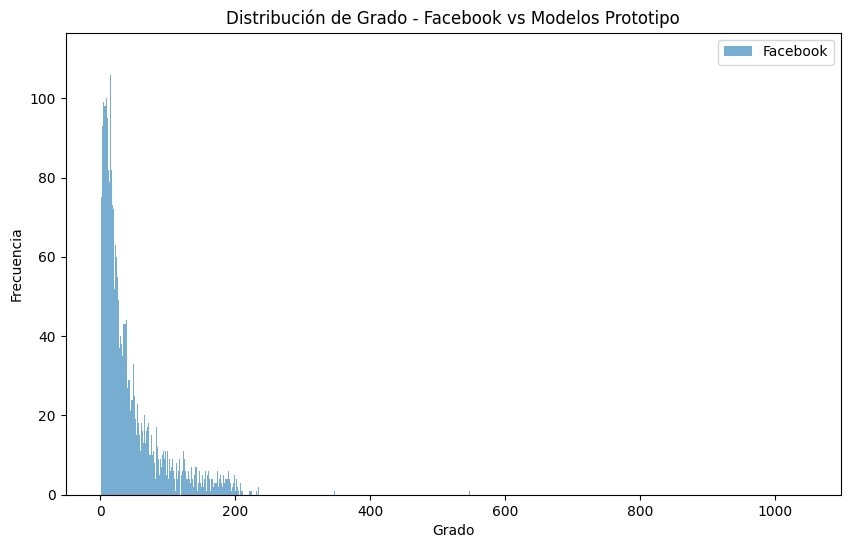

In [ ]:
G = fb
def plot_degree_distribution(G, label):
    degrees = [d for _, d in G.degree()]
    plt.hist(degrees, bins=range(1, max(degrees)+1), alpha=0.6, label=label)

plt.figure(figsize=(10, 6))
plot_degree_distribution(G, "Facebook")
#plot_degree_distribution(G_er, "Erdős-Rényi")
#plot_degree_distribution(G_ws, "Watts-Strogatz")
#plot_degree_distribution(G_ba, "Barabási-Albert")
plt.xlabel("Grado")
plt.ylabel("Frecuencia")
plt.legend()
plt.title("Distribución de Grado - Facebook vs Modelos Prototipo")
plt.show()

# Centralidad de Intermediacion

## Aeropuertos

In [ ]:
G_obs = airU

layout = nx.spring_layout(G_obs, iterations=1000, seed=42)

centrality = nx.betweenness_centrality(G_obs)  # sin peso
values = np.array(list(centrality.values()))

# 3️⃣ Escalar el tamaño de los nodos según la centralidad
node_sizes = 300 + (values / values.max()) * 1000

# 4️⃣ Dibujar nodos coloreados por centralidad
plt.figure(figsize=(12, 9))
nodes = nx.draw_networkx_nodes(
    G_obs,
    layout,
    node_size=node_sizes,
    node_color=values,
    cmap=plt.cm.plasma,
    edgecolors='black',
    linewidths=0.5
)

# 5️⃣ Dibujar etiquetas de nodos
nx.draw_networkx_labels(
    G_obs,
    layout,
    font_size=9,
    font_color='black',
    font_weight='bold'
)

# 6️⃣ Dibujar aristas (todas iguales)
nx.draw_networkx_edges(
    G_obs,
    layout,
    width=1.0,       # ancho fijo (ya que el grafo es binarizado)
    alpha=0.6,
    edge_color='gray'
)

# 7️⃣ Barra de color para la centralidad
cbar = plt.colorbar(nodes, shrink=0.8)
cbar.set_label('Centralidad de intermediación', fontsize=12)

# 8️⃣ Ajustes finales
plt.title("Centralidad de Intermediación (Binaria) del Grafo de Aeropuertos", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


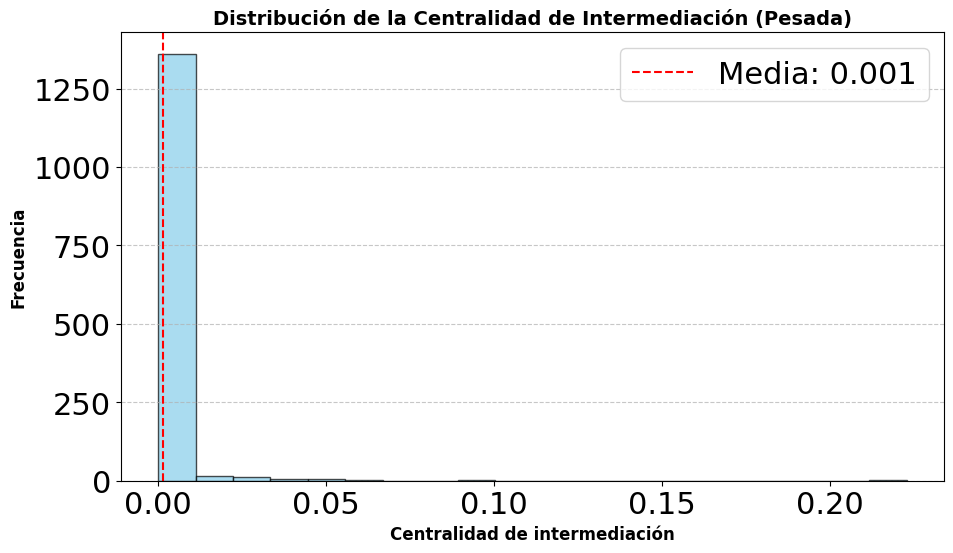

In [ ]:
# Calcular centralidad de intermediación
#centrality = nx.betweenness_centrality(G_obs, weight='weight')
values = list(centrality.values())

# Calcular media (opcional)
mean_val = np.mean(values)

# Crear la figura
plt.figure(figsize=(10, 6))
plt.hist(values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Línea de la media (opcional)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {mean_val:.3f}')

# Personalización de etiquetas y título
plt.xlabel('Centralidad de intermediación', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Distribución de la Centralidad de Intermediación Aeropuertos', fontsize=14, fontweight='bold')

# Leyenda
plt.legend()

# Cuadrícula horizontal para mejor lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()




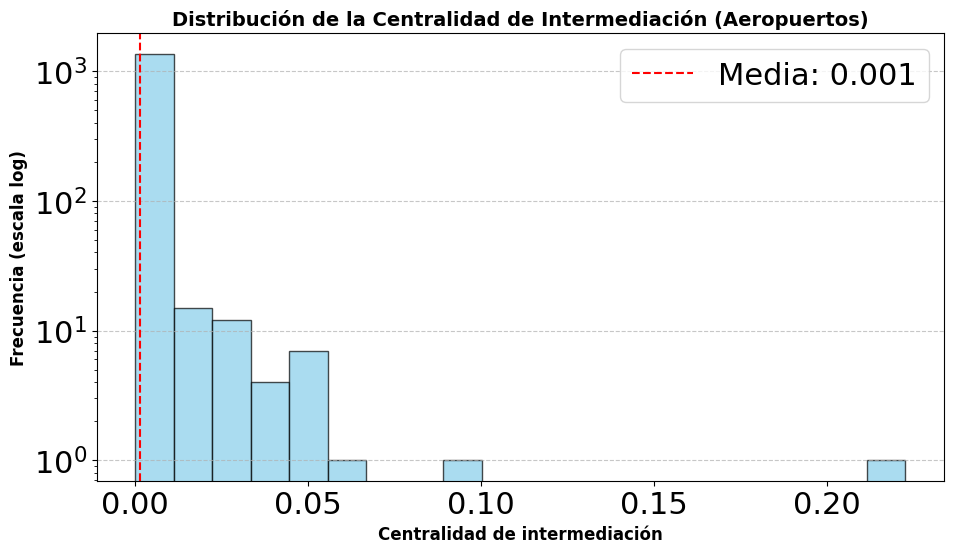

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular centralidad de intermediación
values = list(centrality.values())

# Calcular media (opcional)
mean_val = np.mean(values)

# Crear la figura
plt.figure(figsize=(10, 6))
plt.hist(values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Línea de la media (opcional)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {mean_val:.3f}')

# Personalización de etiquetas y título
plt.xlabel('Centralidad de intermediación', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia (escala log)', fontsize=12, fontweight='bold')
plt.title('Distribución de la Centralidad de Intermediación (Aeropuertos)', fontsize=14, fontweight='bold')

# Usar escala logarítmica en el eje y
plt.yscale('log')

# Leyenda
plt.legend()

# Cuadrícula horizontal para mejor lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
# Convertir el diccionario a DataFrame
centrality_df = pd.DataFrame(
    list(centrality.items()),
    columns=['Nodo', 'Centralidad_Intermediacion']
)

# Ordenar de mayor a menor
centrality_df.sort_values(by='Centralidad_Intermediacion', ascending=False, inplace=True)

# Mostrar la tabla
print(centrality_df)

# (Opcional) Guardar como CSV

DIR = "/content/drive/MyDrive/Maestría en Ciencia de Datos - UBA/FCEN DMCyT"

centrality_df.to_csv(f'{DIR}/centralidad_intermediacion_aeropuertos.csv', index=False)


      Nodo  Centralidad_Intermediacion
29      31                    0.222797
19      21                    0.095793
71      73                    0.057146
144    146                    0.054848
192    194                    0.053646
...    ...                         ...
469    478                    0.000000
1023  1064                    0.000000
1022  1063                    0.000000
1021  1062                    0.000000
1037  1082                    0.000000

[1402 rows x 2 columns]


In [ ]:
# Crear el DataFrame
centrality_df = pd.DataFrame(
    list(centrality.items()),
    columns=['Nodo', 'Centralidad_Intermediacion']
)

# Ajustar centralidades <= 0 a cero
centrality_df['Centralidad_Intermediacion'] = centrality_df['Centralidad_Intermediacion'].apply(lambda x: 0 if x <= 0 else x)

# Separar nodos con centralidad igual a cero
zero_centrality = centrality_df[centrality_df['Centralidad_Intermediacion'] == 0]

# Nodos con centralidad > 0
non_zero_centrality = centrality_df[centrality_df['Centralidad_Intermediacion'] > 0]

# Definir límites para los bins (desde 0 hasta el máximo)
min_val = 0
max_val = non_zero_centrality['Centralidad_Intermediacion'].max()

# Definir los bins (5 intervalos iguales)
bins = np.linspace(min_val, max_val, 6)  # 6 bordes = 5 intervalos

# Asignar bins a los nodos con centralidad > 0
non_zero_centrality['Centralidad_Bin'] = pd.cut(
    non_zero_centrality['Centralidad_Intermediacion'],
    bins=bins,
    include_lowest=False,  # para que el cero no entre en el primer bin
    precision=4
)

# Calcular frecuencias absolutas para nodos con centralidad > 0
bin_counts = non_zero_centrality['Centralidad_Bin'].value_counts().sort_index()

# Crear DataFrame para valores > 0
freq_df_non_zero = bin_counts.reset_index()
freq_df_non_zero.columns = ['Rango de Centralidad', 'Frecuencia Absoluta']

# Convertir el rango a string para que sea más limpio
freq_df_non_zero['Rango de Centralidad'] = freq_df_non_zero['Rango de Centralidad'].astype(str)

# Crear fila para centralidad = 0
freq_df_zero = pd.DataFrame({
    'Rango de Centralidad': ['0'],
    'Frecuencia Absoluta': [len(zero_centrality)]
})

# Combinar la fila cero con el resto
final_freq_df = pd.concat([freq_df_zero, freq_df_non_zero], ignore_index=True)

# Mostrar la tabla final
print(final_freq_df)


  Rango de Centralidad  Frecuencia Absoluta
0                    0                  461
1       (0.0, 0.04456]                  931
2   (0.04456, 0.08912]                    8
3    (0.08912, 0.1337]                    1
4     (0.1337, 0.1782]                    0
5     (0.1782, 0.2228]                    1


<ipython-input-38-4ca05167de5f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_centrality['Centralidad_Bin'] = pd.cut(


## Facebook

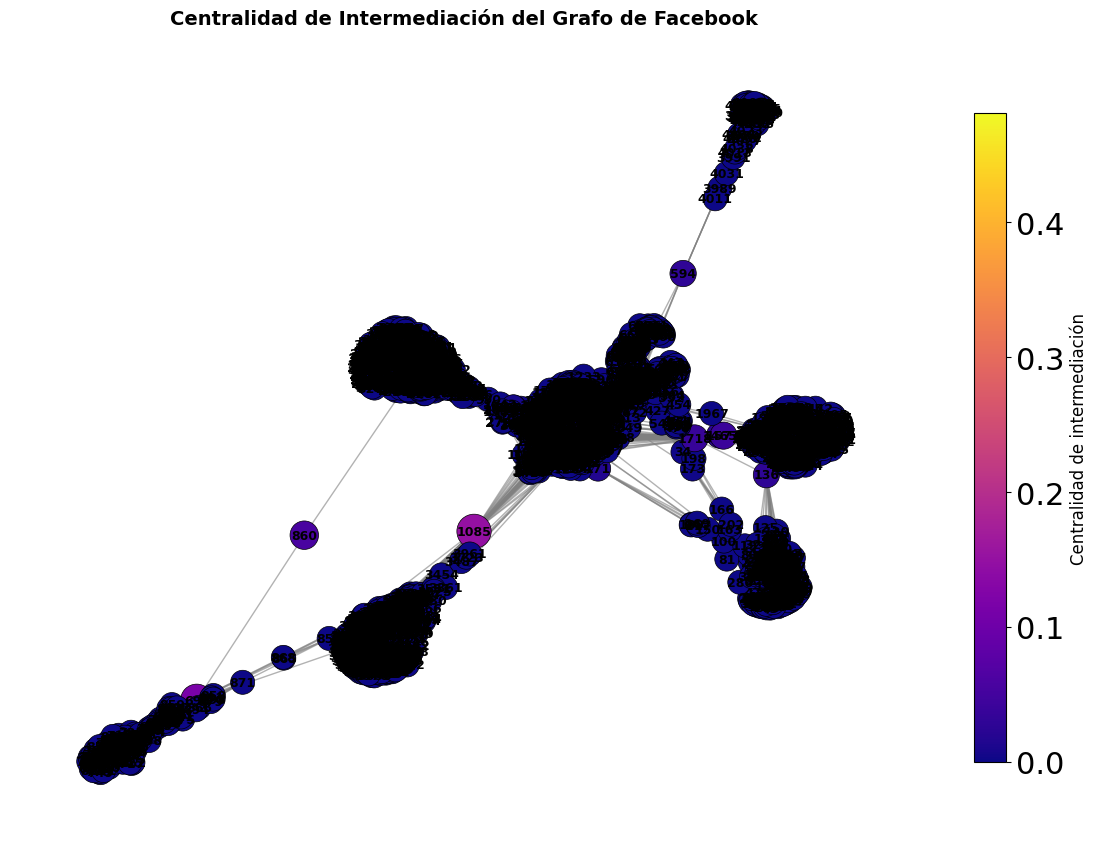

In [ ]:
G_obs = fb

# 1️⃣ Layout del grafo
layout = nx.spring_layout(G_obs, iterations=1000, seed=42)

# 2️⃣ Calcular centralidad de intermediación
centrality = nx.betweenness_centrality(G_obs)  # sin peso
values = np.array(list(centrality.values()))

# 3️⃣ Escalar el tamaño de los nodos según la centralidad
node_sizes = 300 + (values / values.max()) * 1000

# 4️⃣ Dibujar nodos coloreados por centralidad
plt.figure(figsize=(12, 9))
nodes = nx.draw_networkx_nodes(
    G_obs,
    layout,
    node_size=node_sizes,
    node_color=values,
    cmap=plt.cm.plasma,
    edgecolors='black',
    linewidths=0.5
)

# 5️⃣ Dibujar etiquetas de nodos
nx.draw_networkx_labels(
    G_obs,
    layout,
    font_size=9,
    font_color='black',
    font_weight='bold'
)

# 6️⃣ Dibujar aristas (todas iguales)
nx.draw_networkx_edges(
    G_obs,
    layout,
    width=1.0,
    alpha=0.6,
    edge_color='gray'
)

# 7️⃣ Barra de color para la centralidad
cbar = plt.colorbar(nodes, shrink=0.8)
cbar.set_label('Centralidad de intermediación', fontsize=12)

# 8️⃣ Ajustes finales
plt.title("Centralidad de Intermediación del Grafo de Facebook", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


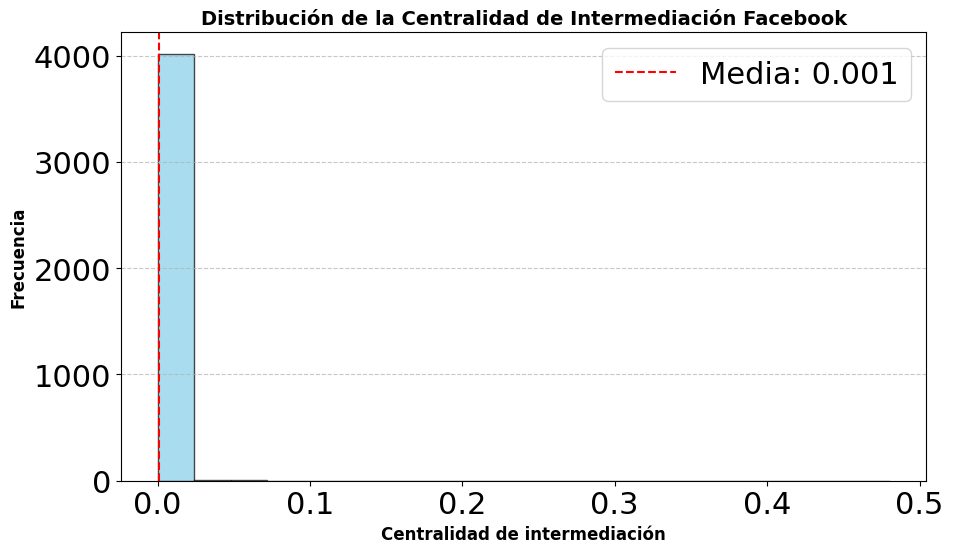

In [ ]:
# Calcular centralidad de intermediación
#centrality = nx.betweenness_centrality(G_obs, weight='weight')
values = list(centrality.values())

# Calcular media (opcional)
mean_val = np.mean(values)

# Crear la figura
plt.figure(figsize=(10, 6))
plt.hist(values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Línea de la media (opcional)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {mean_val:.3f}')

# Personalización de etiquetas y título
plt.xlabel('Centralidad de intermediación', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Distribución de la Centralidad de Intermediación Facebook', fontsize=14, fontweight='bold')

# Leyenda
plt.legend()

# Cuadrícula horizontal para mejor lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

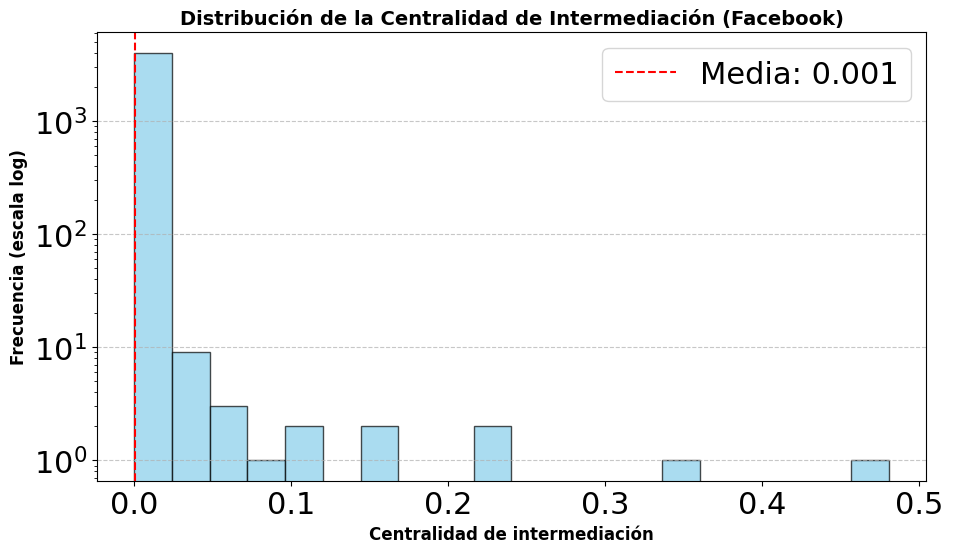

In [ ]:
# Calcular centralidad de intermediación
values = list(centrality.values())

# Calcular media (opcional)
mean_val = np.mean(values)

# Crear la figura
plt.figure(figsize=(10, 6))
plt.hist(values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Línea de la media (opcional)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1.5, label=f'Media: {mean_val:.3f}')

# Personalización de etiquetas y título
plt.xlabel('Centralidad de intermediación', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia (escala log)', fontsize=12, fontweight='bold')
plt.title('Distribución de la Centralidad de Intermediación (Facebook)', fontsize=14, fontweight='bold')

# Usar escala logarítmica en el eje y
plt.yscale('log')

# Leyenda
plt.legend()

# Cuadrícula horizontal para mejor lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
# Convertir el diccionario a DataFrame
centrality_degree_fb = pd.DataFrame(
    list(centrality.items()),
    columns=['Nodo', 'Centralidad_Intermediacion']
)

# Ordenar de mayor a menor
centrality_degree_fb.sort_values(by='Centralidad_Intermediacion', ascending=False, inplace=True)

# Mostrar la tabla
print(centrality_degree_fb)

# (Opcional) Guardar como CSV

#DIR = "/content/drive/MyDrive/Maestría en Ciencia de Datos - UBA/FCEN DMCyT"

#centrality_df.to_csv(f'{DIR}/centralidad_intermediacion_facebook.csv', index=False)

      Nodo  Centralidad_Intermediacion
107    107                    0.480518
351   1684                    0.337797
1821  3437                    0.236115
352   1912                    0.229295
571   1085                    0.149015
...    ...                         ...
1715   572                    0.000000
1714   571                    0.000000
1732   673                    0.000000
1731   652                    0.000000
354   2838                    0.000000

[4039 rows x 2 columns]


In [ ]:
# Crear el DataFrame
centrality_df = pd.DataFrame(
    list(centrality.items()),
    columns=['Nodo', 'Centralidad_Intermediacion']
)

# Ajustar centralidades <= 0 a cero
centrality_df['Centralidad_Intermediacion'] = centrality_df['Centralidad_Intermediacion'].apply(lambda x: 0 if x <= 0 else x)

# Separar nodos con centralidad igual a cero
zero_centrality = centrality_df[centrality_df['Centralidad_Intermediacion'] == 0]

# Nodos con centralidad > 0
non_zero_centrality = centrality_df[centrality_df['Centralidad_Intermediacion'] > 0]

# Definir límites para los bins (desde 0 hasta el máximo)
min_val = 0
max_val = non_zero_centrality['Centralidad_Intermediacion'].max()

# Definir los bins (5 intervalos iguales)
bins = np.linspace(min_val, max_val, 6)  # 6 bordes = 5 intervalos

# Asignar bins a los nodos con centralidad > 0
non_zero_centrality['Centralidad_Bin'] = pd.cut(
    non_zero_centrality['Centralidad_Intermediacion'],
    bins=bins,
    include_lowest=False,  # para que el cero no entre en el primer bin
    precision=4
)

# Calcular frecuencias absolutas para nodos con centralidad > 0
bin_counts = non_zero_centrality['Centralidad_Bin'].value_counts().sort_index()

# Crear DataFrame para valores > 0
freq_df_non_zero = bin_counts.reset_index()
freq_df_non_zero.columns = ['Rango de Centralidad', 'Frecuencia Absoluta']

# Convertir el rango a string para que sea más limpio
freq_df_non_zero['Rango de Centralidad'] = freq_df_non_zero['Rango de Centralidad'].astype(str)

# Crear fila para centralidad = 0
freq_df_zero = pd.DataFrame({
    'Rango de Centralidad': ['0'],
    'Frecuencia Absoluta': [len(zero_centrality)]
})

# Combinar la fila cero con el resto
final_freq_df = pd.concat([freq_df_zero, freq_df_non_zero], ignore_index=True)

# Mostrar la tabla final
print(final_freq_df)


  Rango de Centralidad  Frecuencia Absoluta
0                    0                  342
1        (0.0, 0.0961]                 3689
2     (0.0961, 0.1922]                    4
3     (0.1922, 0.2883]                    2
4     (0.2883, 0.3844]                    1
5     (0.3844, 0.4805]                    1


<ipython-input-11-4ca05167de5f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_centrality['Centralidad_Bin'] = pd.cut(


# Centralidad de Grado

## Facebook

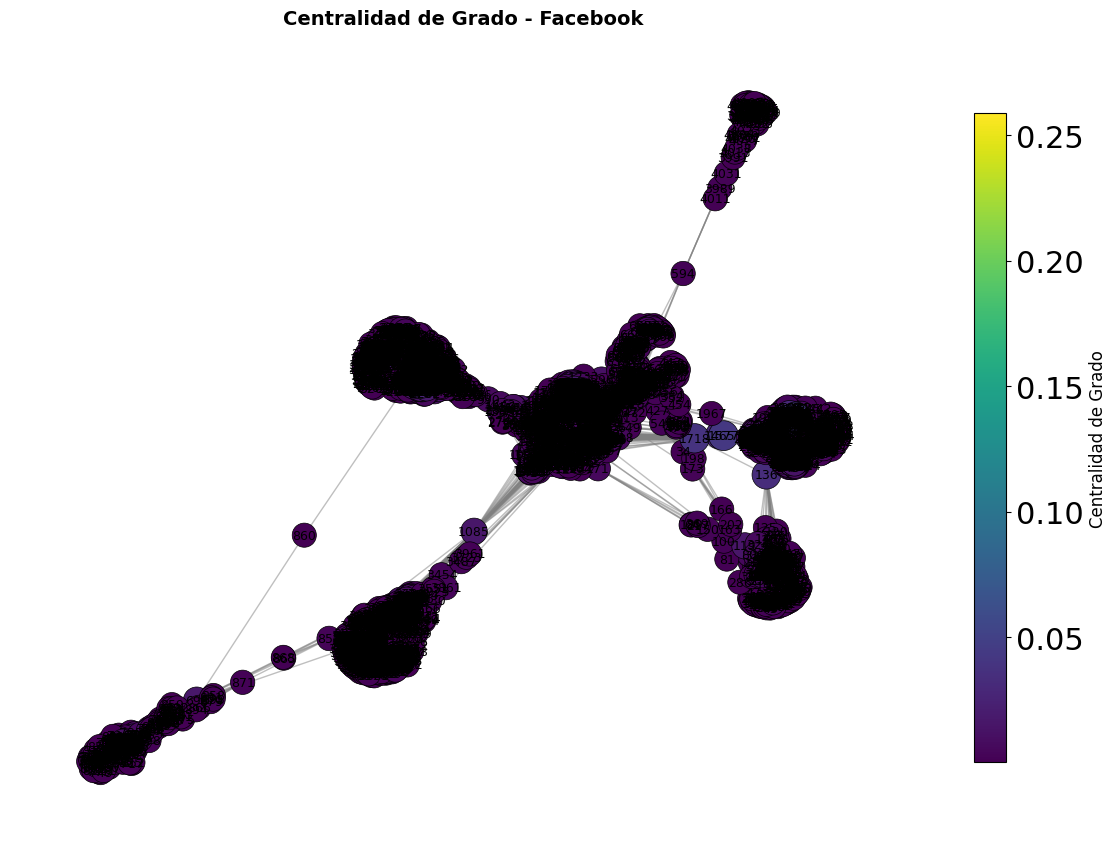

In [ ]:
G_fb = fb

layout_fb = nx.spring_layout(G_fb, seed=42, iterations=1000)

degree_centrality_fb = nx.degree_centrality(G_fb) # Centralidad de grado
values_fb = np.array(list(degree_centrality_fb.values()))
node_sizes_fb = 300 + (values_fb / values_fb.max()) * 1000

# Dibujar nodos
plt.figure(figsize=(12, 9))
nodes_fb = nx.draw_networkx_nodes(
    G_fb,
    layout_fb,
    node_size=node_sizes_fb,
    node_color=values_fb,
    cmap=plt.cm.viridis,
    edgecolors='black',
    linewidths=0.5
)

# Etiquetas de nodos (opcional)
nx.draw_networkx_labels(G_fb, layout_fb, font_size=9, font_color='black')

# Aristas
nx.draw_networkx_edges(G_fb, layout_fb, width=1.0, alpha=0.5, edge_color='gray')

# Barra de color
cbar = plt.colorbar(nodes_fb, shrink=0.8)
cbar.set_label('Centralidad de Grado', fontsize=12)

# Título
plt.title("Centralidad de Grado - Facebook", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Crear DataFrame y ordenarlo
centrality_degree_fb = pd.DataFrame(list(degree_centrality_fb.items()),columns=['Nodo', 'Centralidad_Grado']).sort_values(by='Centralidad_Grado', ascending=False)

# Mostrar los 10 nodos más centrales
print("📌 Top 10 nodos por centralidad de grado (Facebook):")
print(centrality_degree_fb.head(10))

DIR = "/content/drive/MyDrive/Maestría en Ciencia de Datos - UBA/FCEN DMCyT"

centrality_degree_fb.to_csv(f'{DIR}/centralidad_grado_facebook.csv', index=False)


📌 Top 10 nodos por centralidad de grado (Facebook):
      Nodo  Centralidad_Grado
107    107           0.258791
351   1684           0.196137
352   1912           0.186974
1821  3437           0.135463
0        0           0.085934
1490  2543           0.072808
2154  2347           0.072065
1373  1888           0.062902
1285  1800           0.060674
1149  1663           0.058197


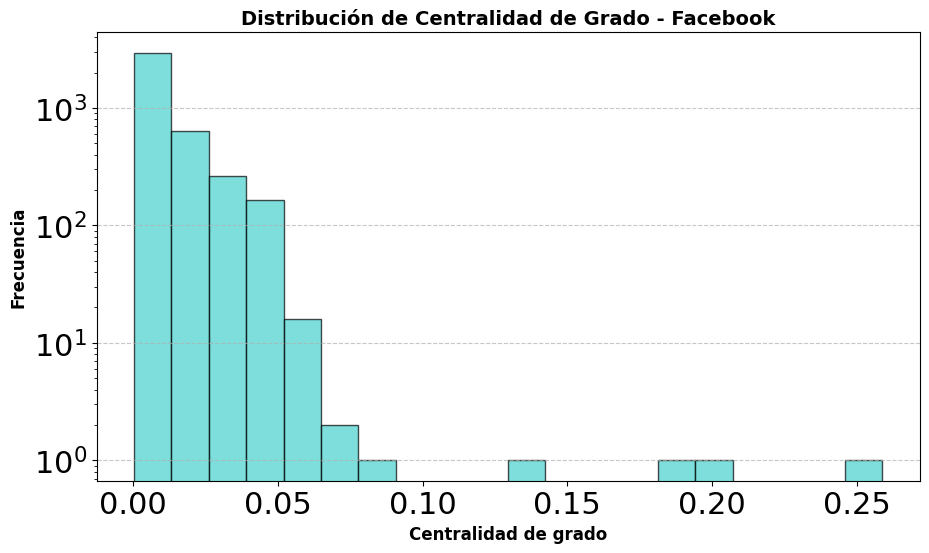

In [ ]:
# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(centrality_degree_fb['Centralidad_Grado'], bins=20, color='mediumturquoise', edgecolor='black', alpha=0.7)
plt.xlabel('Centralidad de grado', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Distribución de Centralidad de Grado - Facebook', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
# Usar escala logarítmica en el eje y
plt.yscale('log')
plt.show()

In [ ]:
betweenness_centrality_fb = nx.betweenness_centrality(fb)

degree_centrality_fb = nx.degree_centrality(fb)

df_grado_fb = pd.DataFrame(degree_centrality_fb.items(), columns=['Nodo', 'Centralidad_Grado'])
df_bet_fb = pd.DataFrame(betweenness_centrality_fb.items(), columns=['Nodo', 'Centralidad_Intermediacion'])

# Unir por 'Nodo'
df_fb_combined = pd.merge(df_grado_fb, df_bet_fb, on='Nodo')

# Ordenar por centralidad de grado (opcional)
df_fb_combined.sort_values(by='Centralidad_Grado', ascending=False, inplace=True)

# Mostrar primeros registros
print("📘 Centralidades combinadas - Facebook")
print(df_fb_combined.head(10))


📘 Centralidades combinadas - Facebook
      Nodo  Centralidad_Grado  Centralidad_Intermediacion
107    107           0.258791                    0.480518
351   1684           0.196137                    0.337797
352   1912           0.186974                    0.229295
1821  3437           0.135463                    0.236115
0        0           0.085934                    0.146306
1490  2543           0.072808                    0.007605
2154  2347           0.072065                    0.003200
1373  1888           0.062902                    0.000118
1285  1800           0.060674                    0.000153
1149  1663           0.058197                    0.001100


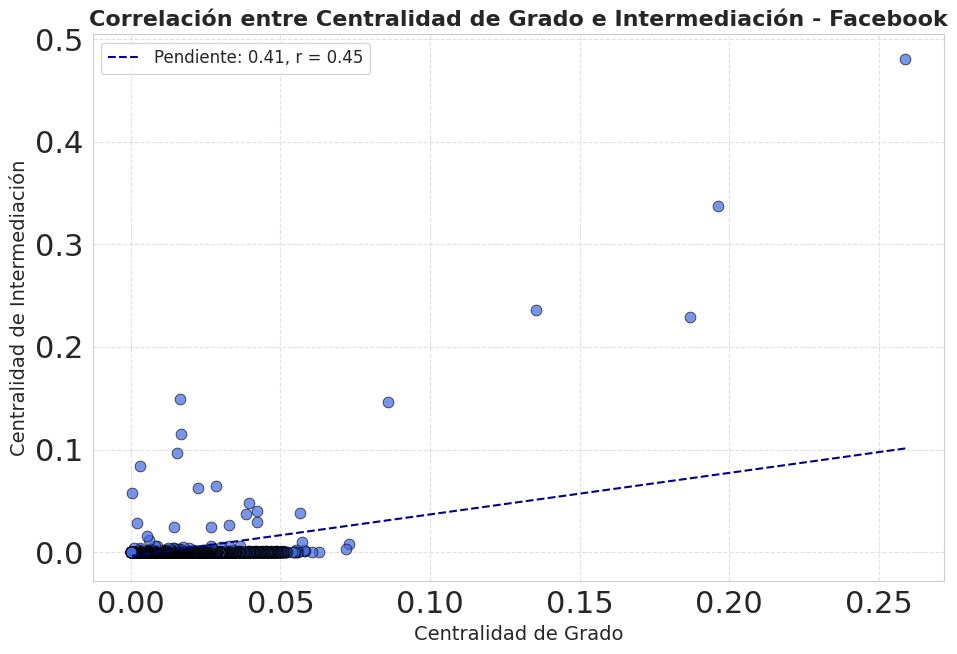

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Estilo académico limpio
sns.set_style("whitegrid")

# Crear la figura
plt.figure(figsize=(10, 7))

# Graficar los puntos
sns.scatterplot(
    data=df_fb_combined,
    x='Centralidad_Grado',
    y='Centralidad_Intermediacion',
    color='royalblue',
    alpha=0.7,
    edgecolor='black',  # bordes para que los puntos se vean más definidos
    s=60                # tamaño de los puntos
)

# Ajustar línea de tendencia (opcional)
slope, intercept, r_value, p_value, std_err = linregress(
    df_fb_combined['Centralidad_Grado'],
    df_fb_combined['Centralidad_Intermediacion']
)
x_vals = df_fb_combined['Centralidad_Grado']
plt.plot(x_vals, intercept + slope * x_vals, color='darkblue', linestyle='--', label=f'Pendiente: {slope:.2f}, r = {r_value:.2f}')

# Títulos y etiquetas con tamaño ajustado
plt.title("Correlación entre Centralidad de Grado e Intermediación - Facebook", fontsize=16, weight='bold')
plt.xlabel("Centralidad de Grado", fontsize=14)
plt.ylabel("Centralidad de Intermediación", fontsize=14)

# Mostrar leyenda de la línea de tendencia
plt.legend(fontsize=12, loc='best')

# Ajustar la cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()


In [ ]:
from scipy.stats import pearsonr, spearmanr

# Extraer columnas como arrays
x_fb = df_fb_combined['Centralidad_Grado']
y_fb = df_fb_combined['Centralidad_Intermediacion']

# Pearson
pearson_corr_fb, pval_pearson_fb = pearsonr(x_fb, y_fb)

# Spearman
spearman_corr_fb, pval_spearman_fb = spearmanr(x_fb, y_fb)

print("📘 Facebook - Correlación entre centralidades")
print(f"📈 Pearson:  r = {pearson_corr_fb:.4f}, p-valor = {pval_pearson_fb:.4e}")
print(f"📊 Spearman: ρ = {spearman_corr_fb:.4f}, p-valor = {pval_spearman_fb:.4e}")


📘 Facebook - Correlación entre centralidades
📈 Pearson:  r = 0.4515, p-valor = 3.7985e-202
📊 Spearman: ρ = 0.7881, p-valor = 0.0000e+00


## Aeropuertos

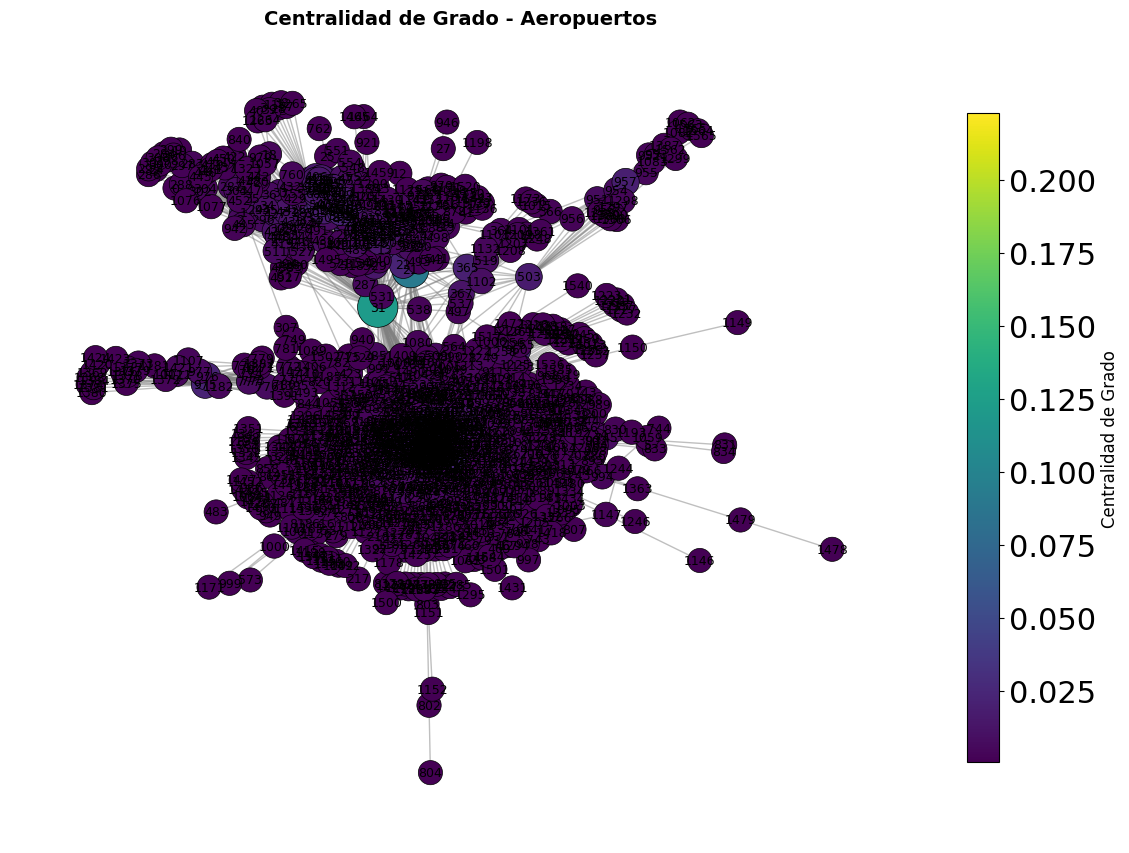

In [ ]:
G_air = airU
# Layout del grafo
layout_air = nx.spring_layout(G_air, seed=42, iterations=1000)

# Centralidad de grado
degree_centrality_air = nx.degree_centrality(G_air)
values_air = np.array(list(degree_centrality_air.values()))
node_sizes_air = 300 + (values_air / values_air.max()) * 1000

# Dibujar nodos
plt.figure(figsize=(12, 9))
nodes_air = nx.draw_networkx_nodes(
    G_air,
    layout_air,
    node_size=node_sizes_air,
    node_color=values_air,
    cmap=plt.cm.viridis,
    edgecolors='black',
    linewidths=0.5
)

# Etiquetas de nodos (opcional)
nx.draw_networkx_labels(G_air, layout_air, font_size=9, font_color='black')

# Aristas
nx.draw_networkx_edges(G_air, layout_air, width=1.0, alpha=0.5, edge_color='gray')

# Barra de color
cbar = plt.colorbar(nodes_air, shrink=0.8)
cbar.set_label('Centralidad de Grado', fontsize=12)

# Título
plt.title("Centralidad de Grado - Aeropuertos", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Crear DataFrame y ordenarlo
centrality_degree_air = pd.DataFrame(list(degree_centrality_air.items()),columns=['Nodo', 'Centralidad_Grado']).sort_values(by='Centralidad_Grado', ascending=False)
# Mostrar los 10 nodos más centrales
print("📌 Top 10 nodos por centralidad de grado (Aeropuertos):")
print(centrality_degree_air.head(10))

DIR = "/content/drive/MyDrive/Maestría en Ciencia de Datos - UBA/FCEN DMCyT"

centrality_degree_air.to_csv(f'{DIR}/centralidad_grado_aeropuertos.csv', index=False)


📌 Top 10 nodos por centralidad de grado (Aeropuertos):
     Nodo  Centralidad_Grado
43     45           0.222698
85     87           0.210564
66     68           0.209850
162   164           0.203426
71     73           0.202712
144   146           0.195575
147   149           0.192719
171   173           0.191292
156   158           0.190578
309   316           0.182013


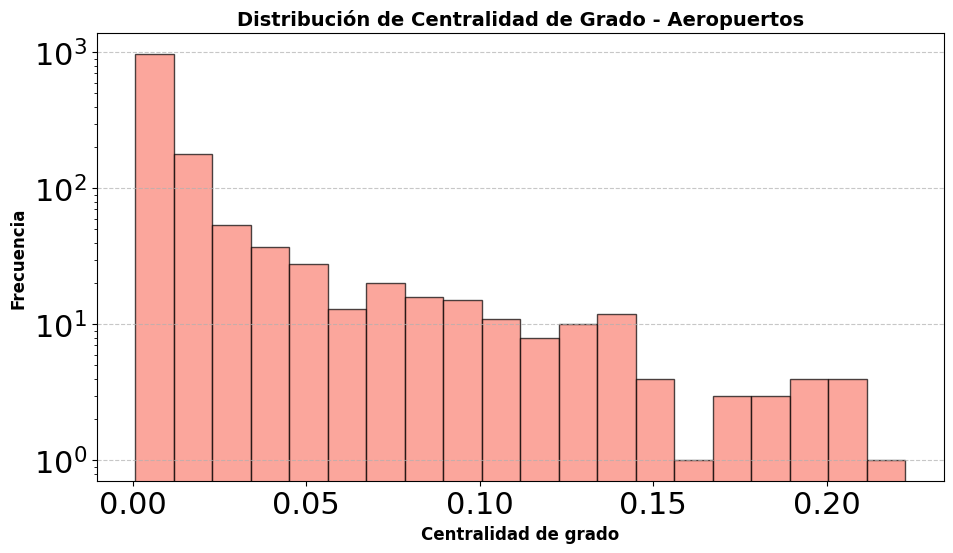

In [ ]:
# Graficar histograma
plt.figure(figsize=(10, 6))
plt.hist(centrality_degree_air['Centralidad_Grado'], bins=20, color='salmon', edgecolor='black', alpha=0.7)
plt.xlabel('Centralidad de grado', fontsize=12, fontweight='bold')
plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
plt.title('Distribución de Centralidad de Grado - Aeropuertos', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Usar escala logarítmica en el eje y
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
# degree_centrality_air y centrality (betweenness de airU)

betweenness_centrality_air = nx.betweenness_centrality(airU)

degree_centrality_air = nx.degree_centrality(airU)

df_grado_air = pd.DataFrame(degree_centrality_air.items(), columns=['Nodo', 'Centralidad_Grado'])
df_bet_air = pd.DataFrame(betweenness_centrality_air.items(), columns=['Nodo', 'Centralidad_Intermediacion'])

df_air_combined = pd.merge(df_grado_air, df_bet_air, on='Nodo')
df_air_combined.sort_values(by='Centralidad_Grado', ascending=False, inplace=True)

print("✈️ Centralidades combinadas - Aeropuertos")
print(df_air_combined.head(10))


✈️ Centralidades combinadas - Aeropuertos
     Nodo  Centralidad_Grado  Centralidad_Intermediacion
43     45           0.222698                    0.048703
85     87           0.210564                    0.025815
66     68           0.209850                    0.038377
162   164           0.203426                    0.051588
71     73           0.202712                    0.057146
144   146           0.195575                    0.054848
147   149           0.192719                    0.029175
171   173           0.191292                    0.045463
156   158           0.190578                    0.034083
309   316           0.182013                    0.050364


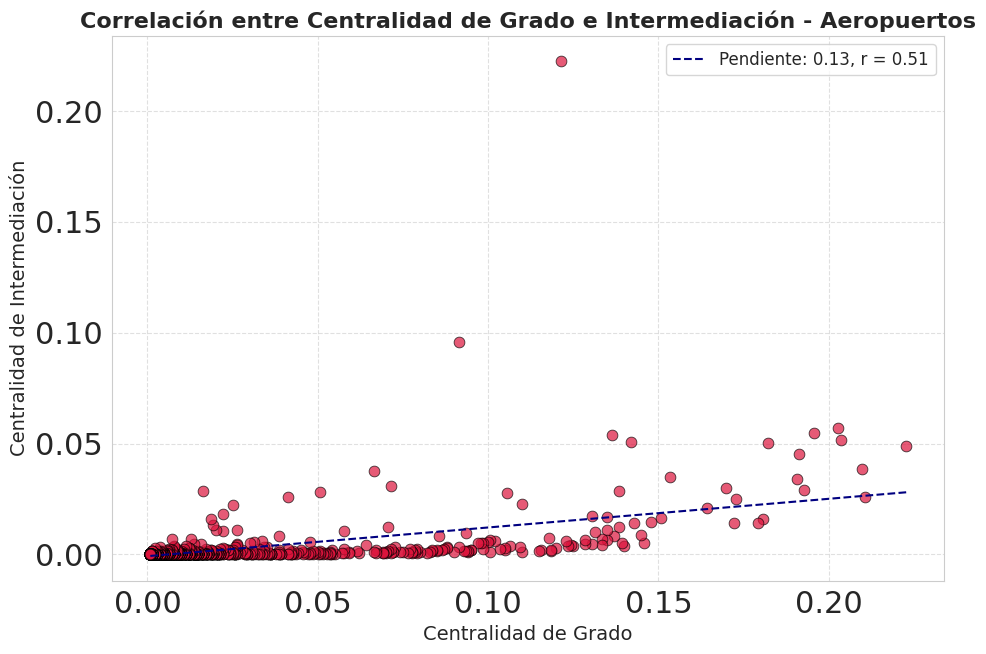

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# Estilo más académico y limpio
sns.set_style("whitegrid")

# Crear la figura
plt.figure(figsize=(10, 7))

# Graficar los puntos
sns.scatterplot(
    data=df_air_combined,
    x='Centralidad_Grado',
    y='Centralidad_Intermediacion',
    color='crimson',
    alpha=0.7,
    edgecolor='black',  # le da un toque más pulido a cada punto
    s=60                # tamaño de los puntos
)

# Ajustar línea de tendencia (opcional, pero recomendado)
slope, intercept, r_value, p_value, std_err = linregress(
    df_air_combined['Centralidad_Grado'],
    df_air_combined['Centralidad_Intermediacion']
)
x_vals = df_air_combined['Centralidad_Grado']
plt.plot(x_vals, intercept + slope * x_vals, color='navy', linestyle='--', label=f'Pendiente: {slope:.2f}, r = {r_value:.2f}')

# Títulos y etiquetas con tamaño ajustado
plt.title("Correlación entre Centralidad de Grado e Intermediación - Aeropuertos", fontsize=16, weight='bold')
plt.xlabel("Centralidad de Grado", fontsize=14)
plt.ylabel("Centralidad de Intermediación", fontsize=14)

# Mostrar leyenda de la línea de tendencia
plt.legend(fontsize=12, loc='best')

# Ajustar la cuadrícula
plt.grid(True, linestyle='--', alpha=0.6)

# Ajustar diseño
plt.tight_layout()

# Mostrar gráfico
plt.show()



In [ ]:
from scipy.stats import pearsonr, spearmanr


# Extraer columnas
x_air = df_air_combined['Centralidad_Grado']
y_air = df_air_combined['Centralidad_Intermediacion']

# Pearson
pearson_corr_air, pval_pearson_air = pearsonr(x_air, y_air)

# Spearman
spearman_corr_air, pval_spearman_air = spearmanr(x_air, y_air)

print("✈️ Aeropuertos - Correlación entre centralidades")
print(f"📈 Pearson:  r = {pearson_corr_air:.4f}, p-valor = {pval_pearson_air:.4e}")
print(f"📊 Spearman: ρ = {spearman_corr_air:.4f}, p-valor = {pval_spearman_air:.4e}")


✈️ Aeropuertos - Correlación entre centralidades
📈 Pearson:  r = 0.5116, p-valor = 2.3939e-94
📊 Spearman: ρ = 0.8461, p-valor = 0.0000e+00


# Comunidades

## Girvan Newman

### Facebook

In [ ]:
G_fb = fb 

def partition_set_to_dict(m):
    d = {}
    for i, c in enumerate(m):
        for n in c:
            d[n] = i
    return d

# Inicializa el generador de particiones con Girvan-Newman
modulos = nx.community.girvan_newman(G_fb)

modularidad = []
mod_max = -999
com_max = None
mejor_iter = 0

# Itera sobre cada partición generada por Girvan-Newman
for step, communities in enumerate(modulos, start=1):
    n_modularidad = nx.community.modularity(
        G_fb,
        tuple(sorted(c) for c in communities)
    )
    modularidad.append(n_modularidad)

    print(f"Iteración {step} - Modularidad: {n_modularidad:.4f} - Comunidades: {len(communities)}")

    # Guardar la primera partición como provisional
    if step == 1 and com_max is None:
        mod_max = n_modularidad
        com_max = tuple(sorted(c) for c in communities)
        mejor_iter = step
        with open("best_partition.pkl", "wb") as f:
            pickle.dump({
                "iter": mejor_iter,
                "modularity": mod_max,
                "partition": com_max
            }, f)
        print(f"Se guardó la primera partición provisional (iteración {step}).")

    # Guardar la partición si mejora la modularidad
    if n_modularidad > mod_max:
        mod_max = n_modularidad
        com_max = tuple(sorted(c) for c in communities)
        mejor_iter = step
        with open("best_partition.pkl", "wb") as f:
            pickle.dump({
                "iter": mejor_iter,
                "modularity": mod_max,
                "partition": com_max
            }, f)
        print(f"Se actualizó la mejor partición (iteración {step}) con modularidad: {mod_max:.4f}.")

print("\nProceso completado.")
print(f"Mejor partición encontrada en la iteración {mejor_iter} con modularidad: {mod_max:.4f}")
print(f"Número de comunidades: {len(com_max)}")


In [ ]:
G_fb = fb  

# Función para transformar la partición a un diccionario
def partition_set_to_dict(m):
    d = {}
    for i, c in enumerate(m):
        for n in c:
            d[n] = i
    return d

# Cargar la mejor partición guardada
try:
    with open("best_partition_fb.pkl", "rb") as f:
        data = pickle.load(f)
        mejor_iter = data["iter"]
        mod_max = data["modularity"]
        com_max = data["partition"]
except FileNotFoundError:
    print("No se encontró el archivo 'best_partition_fb.pkl'. Asegúrate de haber ejecutado el primer script antes.")
    exit()

# Layout: spring_layout con semilla fija
pos = nx.spring_layout(G_fb, iterations=1000)

plt.figure(figsize=(18, 10))

# Colores por comunidad
partition_dict = partition_set_to_dict(com_max)
node_colors = [partition_dict[n] for n in G_fb.nodes()]

# Tamaño de nodo proporcional al grado
node_sizes = [G_fb.degree(n) * 5 for n in G_fb.nodes()]

# Dibujar nodos
nodes = nx.draw_networkx_nodes(
    G_fb,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    edgecolors='black',
    linewidths=0.2,
    alpha=0.9
)

# Dibujar aristas
edge_weights = nx.get_edge_attributes(G_fb, "weight")
if edge_weights:
    edge_widths = np.array(list(edge_weights.values()))
    edge_widths = (edge_widths / np.max(edge_widths)) * 2  # Normalizar a [0,2]
else:
    edge_widths = np.ones(G_fb.number_of_edges()) * 0.5

nx.draw_networkx_edges(
    G_fb,
    pos,
    width=edge_widths,
    alpha=0.3
)

# Etiquetas (opcional, para redes pequeñas)
if G_fb.number_of_nodes() < 50:
    nx.draw_networkx_labels(
        G_fb,
        pos,
        font_weight='bold',
        font_color='white',
        font_size=6
    )

# Título académico
plt.title(
    f"Comunidades detectadas en la Red Social Facebook (Girvan-Newman)\nIteración {mejor_iter} - Modularidad: {mod_max:.4f}",
    fontsize=16,
    fontweight='bold'
)

plt.axis('off')
plt.colorbar(nodes, shrink=0.8, label='Comunidades')
plt.tight_layout()
plt.show()


### Aeropuertos

In [ ]:
G_air = airU  # Tu grafo de aeropuertos

def partition_set_to_dict(m):
    d = {}
    for i, c in enumerate(m):
        for n in c:
            d[n] = i
    return d

# Inicializa el generador de particiones con Girvan-Newman
modulos = nx.community.girvan_newman(G_air)

modularidad = []
mod_max = -999
com_max = None
mejor_iter = 0

# Itera sobre cada partición generada por Girvan-Newman
for step, communities in enumerate(modulos, start=1):
    n_modularidad = nx.community.modularity(
        G_air,
        tuple(sorted(c) for c in communities)
    )
    modularidad.append(n_modularidad)

    print(f"Iteración {step} - Modularidad: {n_modularidad:.4f} - Comunidades: {len(communities)}")

    # Guardar la primera partición como provisional
    if step == 1 and com_max is None:
        mod_max = n_modularidad
        com_max = tuple(sorted(c) for c in communities)
        mejor_iter = step
        with open("best_partition.pkl", "wb") as f:
            pickle.dump({
                "iter": mejor_iter,
                "modularity": mod_max,
                "partition": com_max
            }, f)
        print(f"💾 Se guardó la primera partición provisional (iteración {step}).")

    # Guardar la partición si mejora la modularidad
    if n_modularidad > mod_max:
        mod_max = n_modularidad
        com_max = tuple(sorted(c) for c in communities)
        mejor_iter = step
        with open("best_partition.pkl", "wb") as f:
            pickle.dump({
                "iter": mejor_iter,
                "modularity": mod_max,
                "partition": com_max
            }, f)
        print(f"💾 Se actualizó la mejor partición (iteración {step}) con modularidad: {mod_max:.4f}.")

print("\n✅ Proceso completado.")
print(f"Mejor partición encontrada en la iteración {mejor_iter} con modularidad: {mod_max:.4f}")
print(f"Número de comunidades: {len(com_max)}")


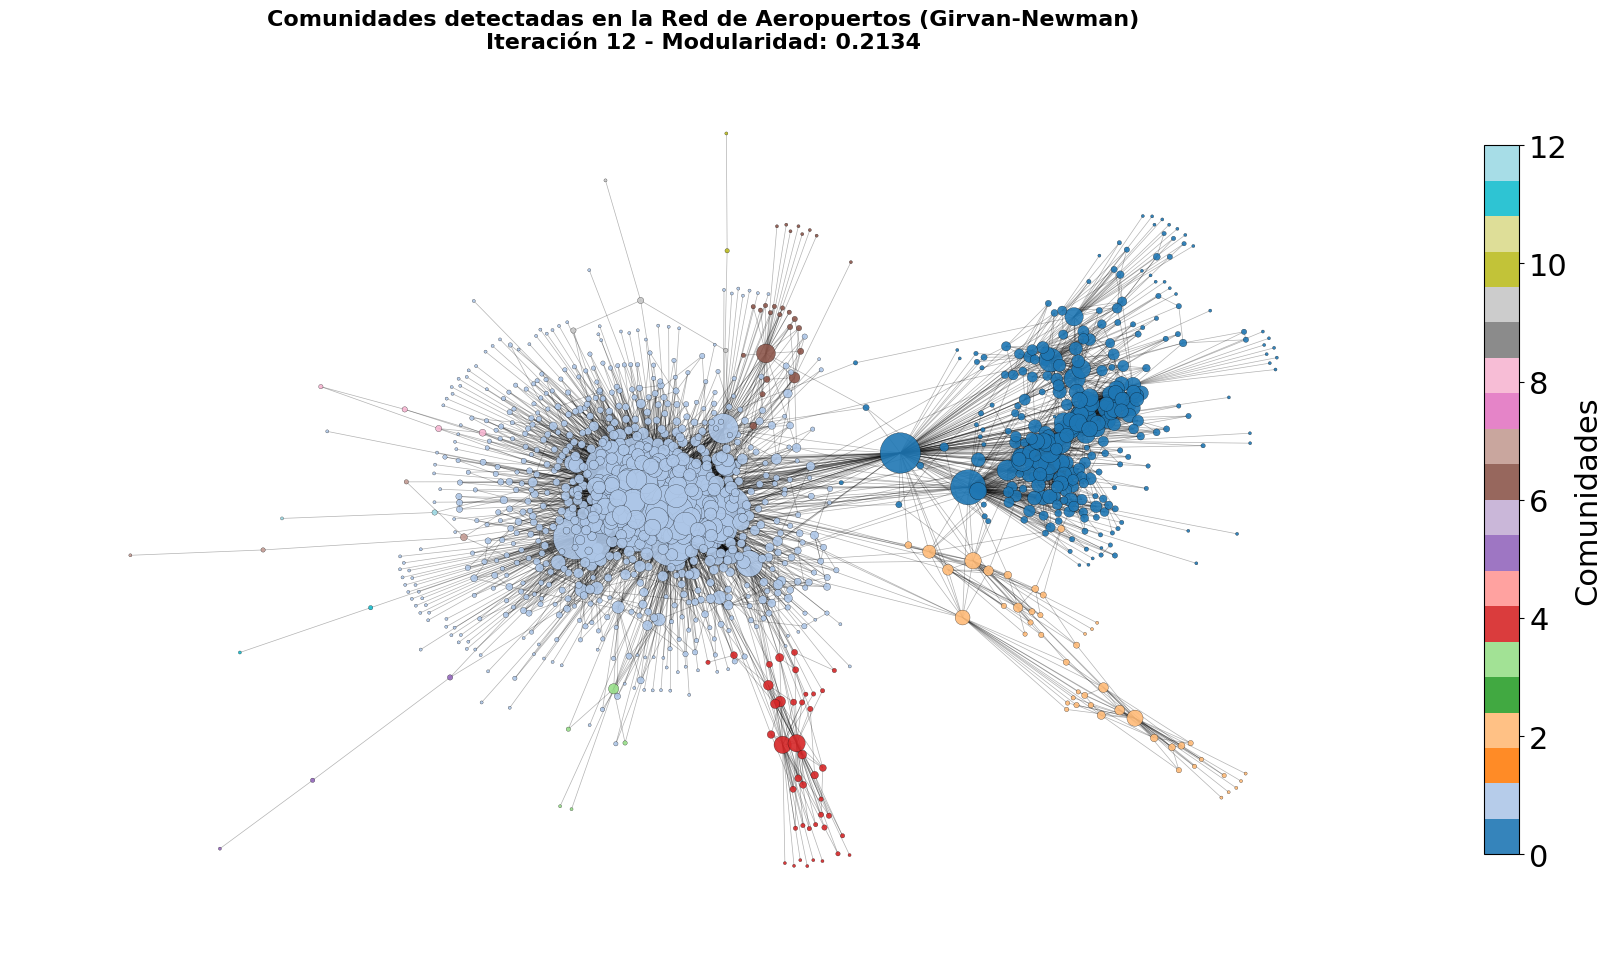

In [14]:
# Suponiendo que ya cargaste tu grafo:
G_air = airU  # Tu grafo ya cargado

# 🔧 Función para transformar la partición (conjuntos de nodos) a un diccionario
def partition_set_to_dict(partition_set):
    partition_dict = {}
    for i, community in enumerate(partition_set):
        for node in community:
            partition_dict[node] = i
    return partition_dict

# 📦 Cargar la mejor partición guardada de Girvan-Newman
try:
    with open("best_partition.pkl", "rb") as f:
        data = pickle.load(f)
        mejor_iter = data["iter"]
        mod_max = data["modularity"]
        com_max = data["partition"]
except FileNotFoundError:
    print("No se encontró el archivo 'best_partition.pkl'. Asegúrate de haber ejecutado el primer script antes.")
    exit()

# 🔍 Layout (spring_layout para respetar la topología)
pos = nx.spring_layout(G_air, iterations=1000)  # semilla para reproducibilidad

plt.figure(figsize=(18, 10))

# 🎨 Colores por comunidad
partition_dict = partition_set_to_dict(com_max)
node_colors = [partition_dict[n] for n in G_air.nodes()]

# 🟢 Tamaño de nodo proporcional al grado
node_sizes = [G_air.degree(n) * 5 for n in G_air.nodes()]

# Dibujar nodos
nodes = nx.draw_networkx_nodes(
    G_air,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    edgecolors='black',
    linewidths=0.2,
    alpha=0.9
)

# Dibujar aristas (considerando pesos)
edge_weights = nx.get_edge_attributes(G_air, "weight")
if edge_weights:
    edge_widths = np.array(list(edge_weights.values()))
    edge_widths = (edge_widths / np.max(edge_widths)) * 2  # Escalar grosor de las aristas
else:
    edge_widths = np.ones(G_air.number_of_edges()) * 0.5

nx.draw_networkx_edges(
    G_air,
    pos,
    width=edge_widths,
    alpha=0.3
)

# Etiquetas (opcional: sólo si es una red pequeña)
if G_air.number_of_nodes() < 50:
    nx.draw_networkx_labels(
        G_air,
        pos,
        font_weight='bold',
        font_color='white',
        font_size=8
    )

# Título
plt.title(
    f"Comunidades detectadas en la Red de Aeropuertos (Girvan-Newman)\nIteración {mejor_iter} - Modularidad: {mod_max:.4f}",
    fontsize=16,
    fontweight='bold'
)

plt.axis('off')
plt.colorbar(nodes, shrink=0.8, label='Comunidades')
plt.tight_layout()
plt.show()


## Louvian

### Facebook

La modularidad de la partición óptima es: 0.835
Número de comunidades detectadas: 16
  Comunidad 1: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65),

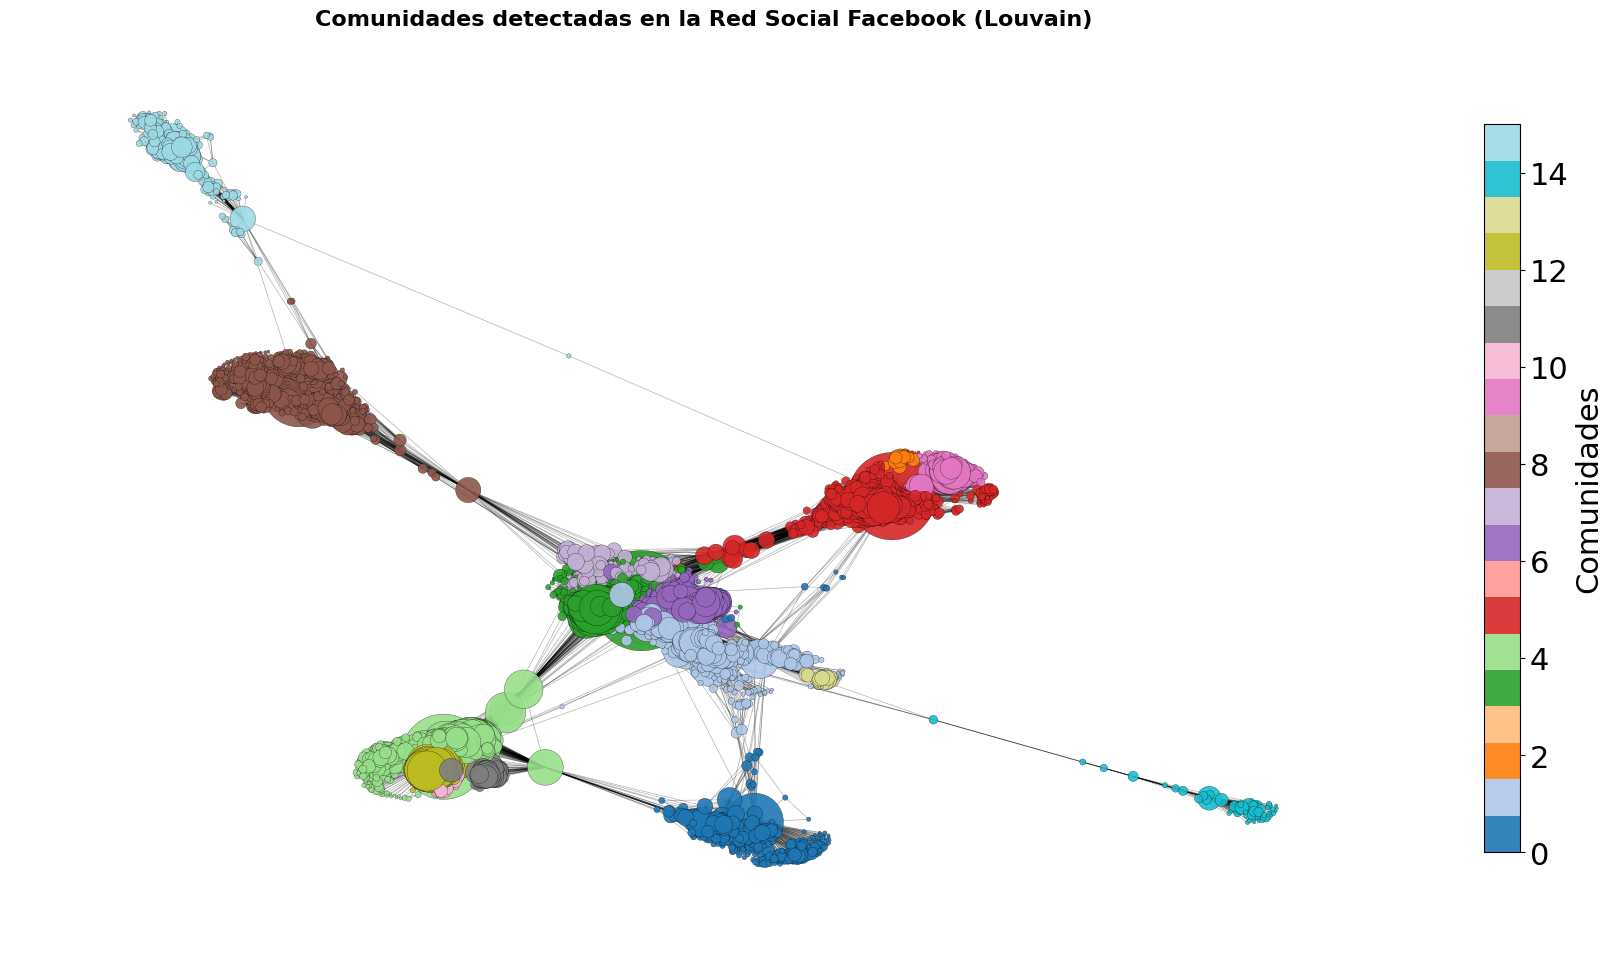

In [ ]:
# Suponemos que ya tienes cargado tu grafo
G_fb = fb

# 1️⃣ Detectar comunidades usando Louvain
partition = community.community_louvain.best_partition(G_fb)

# 2️⃣ Convertir partición a lista de conjuntos
def partition_dict_to_sets(partition):
    community_dict = defaultdict(set)
    for node, community_id in partition.items():
        community_dict[community_id].add(node)
    return list(community_dict.values())

com_max = partition_dict_to_sets(partition)
mod_max = community.community_louvain.modularity(partition, G_fb)

# 3️⃣ Mostrar resultados
print('La modularidad de la partición óptima es:', round(mod_max, 4))
print(f'Número de comunidades detectadas: {len(com_max)}')
for i, c in enumerate(com_max, 1):
    print(f"  Comunidad {i}: {sorted(c)}")

# 4️⃣ Visualización
# Usamos spring_layout para respetar la topología de la red
pos = nx.spring_layout(G_fb, iterations=1000)  # semilla para reproducibilidad

plt.figure(figsize=(18, 10))

# Colores por comunidad
node_colors = [partition[n] for n in G_fb.nodes()]
# Tamaño de nodo proporcional al grado
node_sizes = [G_fb.degree(n) * 5 for n in G_fb.nodes()]

# Dibujar nodos
nodes = nx.draw_networkx_nodes(
    G_fb,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    edgecolors='black',
    linewidths=0.2,
    alpha=0.9
)

# Dibujar aristas (peso si existe)
if nx.get_edge_attributes(G_fb, "weight"):
    edge_weights = nx.get_edge_attributes(G_fb, "weight")
    edge_widths = np.array(list(edge_weights.values()))
    edge_widths = (edge_widths / np.max(edge_widths)) * 2
else:
    edge_widths = np.ones(G_fb.number_of_edges()) * 0.5

nx.draw_networkx_edges(
    G_fb,
    pos,
    width=edge_widths,
    alpha=0.3
)

# Opcional: etiquetas si la red es pequeña
if G_fb.number_of_nodes() < 50:
    nx.draw_networkx_labels(
        G_fb,
        pos,
        font_weight='bold',
        font_color='white',
        font_size=8
    )

plt.title("Comunidades detectadas en la Red Social Facebook (Louvain)",
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.colorbar(nodes, shrink=0.8, label='Comunidades')
plt.tight_layout()
plt.show()


### Aeropuertos

La modularidad de la partición óptima es: 0.3478
Número de comunidades detectadas: 9
  Comunidad 1: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(114), np.int64(115), np.int64(116), np.int64(117), np.int64(118), np.int64(119), np.int64(120), np.int64(121), np.int64(122), np.int64(280), np.int64(282), np.int64(283), np.int64(284), np.int64(286), np.int64(287), np.int64(288), np.int64(289), np.int64(291), np.int64(292), np.int64(293), np.int64(294), np.int64(295), np.int64(296), np.int64(297), np.int64(298), np.int64(29

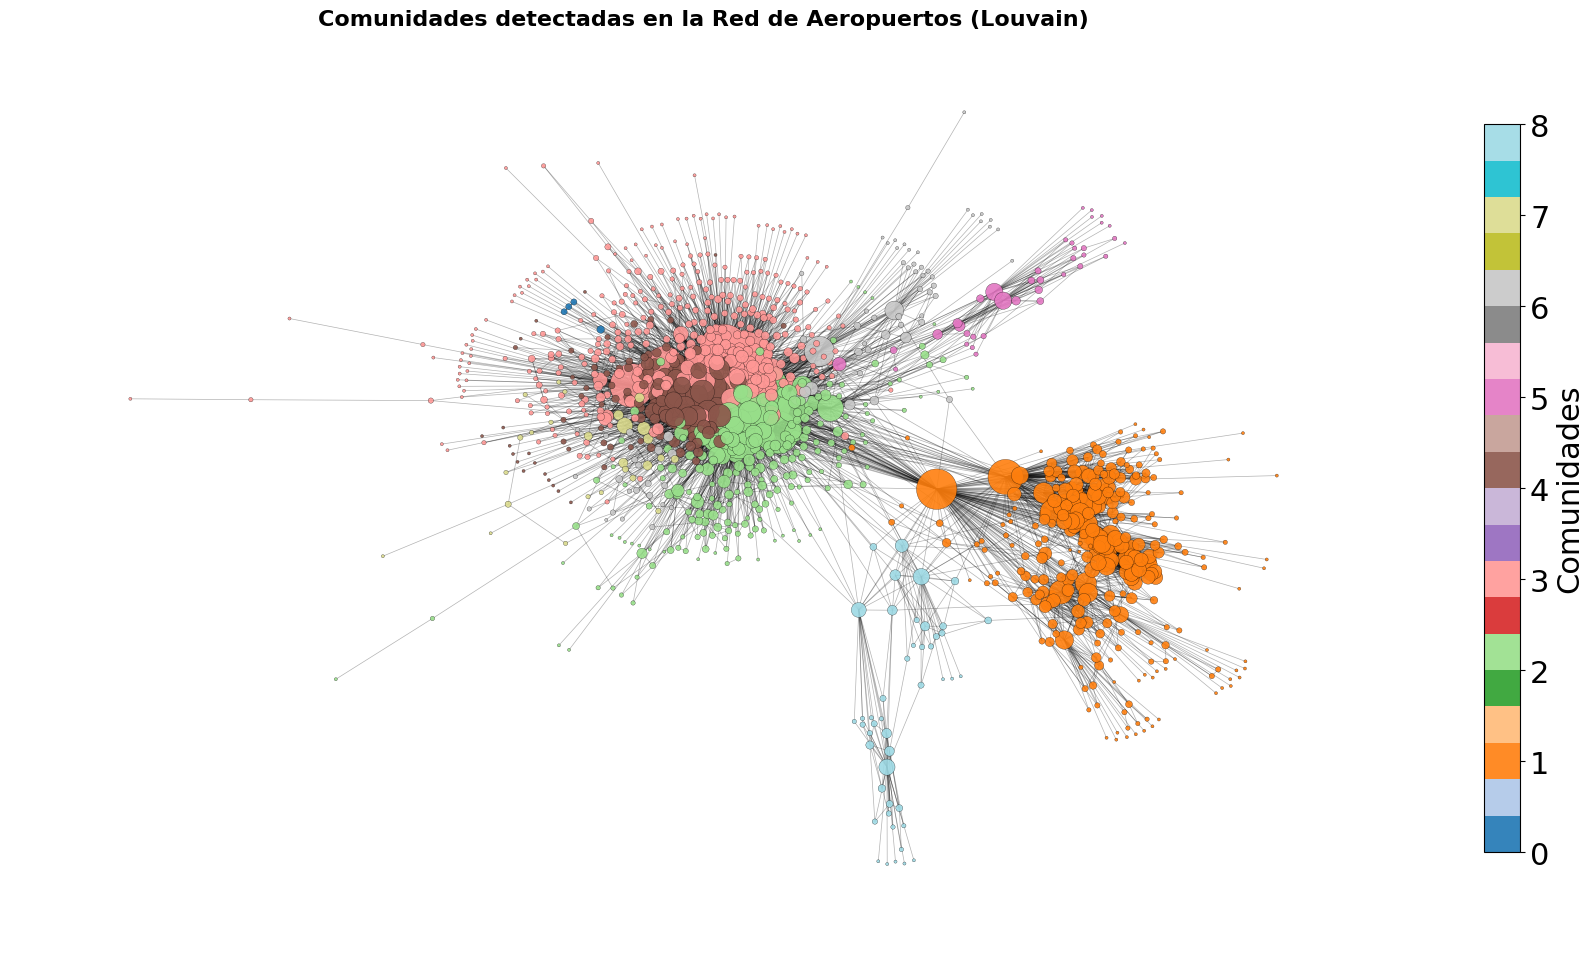

In [ ]:
# Suponemos que ya tienes cargado tu grafo
G_air = airU

# 1️⃣ Detectar comunidades usando Louvain
partition = community.community_louvain.best_partition(G_air)

# 2️⃣ Convertir partición a lista de conjuntos
def partition_dict_to_sets(partition):
    community_dict = defaultdict(set)
    for node, community_id in partition.items():
        community_dict[community_id].add(node)
    return list(community_dict.values())

com_max = partition_dict_to_sets(partition)
mod_max = community.community_louvain.modularity(partition, G_air)

# 3️⃣ Mostrar resultados
print('La modularidad de la partición óptima es:', round(mod_max, 4))
print(f'Número de comunidades detectadas: {len(com_max)}')
for i, c in enumerate(com_max, 1):
    print(f"  Comunidad {i}: {sorted(c)}")

# 4️⃣ Visualización
# Usamos spring_layout para respetar la topología de la red
pos = nx.spring_layout(G_air, iterations=1000)  # semilla para reproducibilidad

plt.figure(figsize=(18, 10))

# Colores por comunidad
node_colors = [partition[n] for n in G_air.nodes()]
# Tamaño de nodo proporcional al grado
node_sizes = [G_air.degree(n) * 5 for n in G_air.nodes()]

# Dibujar nodos
nodes = nx.draw_networkx_nodes(
    G_air,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.tab20,
    edgecolors='black',
    linewidths=0.2,
    alpha=0.9
)

# Dibujar aristas (peso si existe)
if nx.get_edge_attributes(G_air, "weight"):
    edge_weights = nx.get_edge_attributes(G_air, "weight")
    edge_widths = np.array(list(edge_weights.values()))
    edge_widths = (edge_widths / np.max(edge_widths)) * 2
else:
    edge_widths = np.ones(G_air.number_of_edges()) * 0.5

nx.draw_networkx_edges(
    G_air,
    pos,
    width=edge_widths,
    alpha=0.3
)

# Opcional: etiquetas si la red es pequeña
if G_air.number_of_nodes() < 50:
    nx.draw_networkx_labels(
        G_air,
        pos,
        font_weight='bold',
        font_color='white',
        font_size=8
    )

plt.title("Comunidades detectadas en la Red de Aeropuertos (Louvain)",
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.colorbar(nodes, shrink=0.8, label='Comunidades')
plt.tight_layout()
plt.show()
